In [1]:
import pandas as pd
import pylab as pl
import numpy as np
import matplotlib.pyplot as plt
import csv
import pathlib
import os
import networkx as nx 
import matplotlib as mpl
import mpl_toolkits 
from mpl_toolkits.basemap import Basemap as Basemap
%matplotlib inline

# Function Defenition

## Util


In [2]:
def create_directory_if_not_exists(directory_path):
    """
    Create a directory if it does not exist.

    Args:
        directory_path (str): The path of the directory to create.
    """
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)
        print(f"Directory '{directory_path}' created successfully.")
    else:
        print(f"Directory '{directory_path}' already exists.")

In [3]:
def extract_float_h2_percent(input_string):
    parts = input_string.split('_')
    return float(parts[8])

def extract_float_co2_percent(input_string):
    parts = input_string.split('_')
    return float(parts[10][0:3])

def extract_float_sf_percent(input_string):
    parts = input_string.split('_')
    return float(parts[15])


## Data Wrangling Functions

In [4]:
#Get all scenarios in a directory

def get_scenario_names(sen_name):
    lst = os.listdir(os.getcwd())
    lst = list(filter(lambda k: sen_name in k, lst))
    lst = list(filter(lambda k: '.jl' not in k, lst))
    lst = list(filter(lambda k: 'DACNon' not in k, lst))
    
    return lst

def create_fig_dir(directory):
    if not os.path.exists(directory):
        os.mkdir(directory)
        print("Directory created successfully")
    else:
        print("Directory already exists")

def read_cost_data(dir_list, scenario_name_dict, directory_name="./"):
    
    costs_df = pd.DataFrame(columns=["scenario_name", "co2_percent", "h2_percent", "sf_percent", "total_cost", "Power", "H2", "CO2", "SynFuels", "ConvFuels"])

    for dir_name in dir_list:
        
        curr_results_directory =  directory_name + dir_name + "/Results/"
        
        
        cost_df = pd.read_csv(curr_results_directory + "costs_system.csv")
        total_cost = cost_df[cost_df['Costs'] == "cTotal"]['Total'].values[0] * 1e-9
        
        total_cost = cost_df[cost_df['Costs'] == "cTotal"]['Total'].values[0] * 1e-9
        power_cost = cost_df[cost_df['Costs'] == "cPower_Total"]['Total'].values[0] * 1e-9
        h2_cost = cost_df[cost_df['Costs'] == "cHSC_Total"]['Total'].values[0] * 1e-9
        csc_cost = cost_df[cost_df['Costs'] == "cCSC_Total"]['Total'].values[0] * 1e-9
        sf_cost = cost_df[cost_df['Costs'] == "cSF_Prod"]['Total'].values[0] * 1e-9
        conv_fuel_cost = cost_df[cost_df['Costs'] == "cConv_Fuels"]['Total'].values[0] * 1e-9
          
        co2_percent = extract_float_co2_percent(dir_name)
        h2_percent = extract_float_h2_percent(dir_name)
        sf_percent = extract_float_sf_percent(dir_name)
        
        curr_costs_df = pd.DataFrame(index = [scenario_name_dict[dir_name]],
                                     columns=["scenario_name", "co2_percent", "h2_percent", "sf_percent", "total_cost", "Power", "H2", "CO2", "SynFuels", "ConvFuels"],
                                     data=[[scenario_name_dict[dir_name], co2_percent, h2_percent, sf_percent, total_cost, power_cost, h2_cost, csc_cost, sf_cost, conv_fuel_cost]])

        costs_df = costs_df.append(curr_costs_df)
    

    return costs_df


In [5]:
def read_power_data(dir_list, scenario_name_dict, directory_name ="./"):
    
    power_cap_list = []
    power_gen_list = []
    power_battery_cap_list = []
    comb_power_capacity_list = []
    power_gen_zone_list = []
    power_zone_list = []
    power_capacity_zone_list = []

    for dir_name in dir_list:
        
        co2_percent = extract_float_co2_percent(dir_name)
        h2_percent = extract_float_h2_percent(dir_name)
        sf_percent = extract_float_sf_percent(dir_name)

        curr_dir_name = directory_name + dir_name + "/Results/"

        resource_dict = {'CCGT' : 'Gas', 'OCGT' : 'Gas', 'CCGT_CCS' : 'Gas w/ CCS',
             'biomass' : 'Biomass',
             'coal' :'Coal',
             'lignite' : 'Coal',
             'oil' : 'Oil',
             'offwind-dc' : 'Wind - Offshore' , 'offwind-ac' : 'Wind - Offshore', 'onwind' : 'Wind - Onshore',
            'ror' : 'Hydro', 'hydro' : 'Hydro', 'PHS' : 'PHS',
             'solar' : 'Solar',
            'nuclear' : 'Nuclear'}

        #Raw Data
        power_df = pd.read_csv(curr_dir_name + "/power.csv").drop([0,1])
        weights_df = pd.read_csv(curr_dir_name + "/time_weights.csv")
        capacity_df = pd.read_csv(curr_dir_name + "/capacity.csv")

        #########Power###########

        #Wrangle Power Data into long format
        power_long_df = power_df.melt(id_vars = "Resource").query("Resource != 'Zone' & Resource != 'AnnualSum'")

        power_long_df = power_long_df.assign(zone = power_long_df["variable"].str[:5],
                                 resource_type = power_long_df["variable"].str[6:],
                                interval = pd.to_numeric(power_long_df["Resource"].str[1:]) ).replace({"resource_type": resource_dict})
        
        zones = power_long_df["zone"].unique()

        #Add weights to long power data frame
        power_long_df = power_long_df.merge(weights_df, left_on = "interval", right_on = "Time", how = "left")

        #Aggregate power data by zone
        power_zone_df = power_long_df.groupby(['zone','resource_type']).agg({'value': 'sum'}).query("zone != 'Total'").reset_index()
        power_zone_df = power_zone_df.assign(generation_twh = power_zone_df["value"] * 0.000001)
        power_zone_df['scenario'] = scenario_name_dict[dir_name]
        power_zone_df['zone'] = power_zone_df['zone'].str[0:3]
        power_zone_list.append(power_zone_df)

        power_gen_df = power_long_df.query("variable != 'Total'").groupby(['resource_type','interval']).agg({'value': 'sum'}).reset_index()

        #Aggregate power by generator type
        power_gen_total_df = power_long_df.query("variable != 'Total'").assign(gen = power_long_df["value"] * power_long_df["Weight"]).groupby(['resource_type']).agg({'gen': 'sum'}).reset_index()
        power_gen_total_df = power_gen_total_df.assign(generation_twh = power_gen_total_df["gen"] * 0.000001, scenario = scenario_name_dict[dir_name],
                                                      co2_percent = co2_percent , h2_percent = h2_percent, sf_percent = sf_percent)

        power_gen_list.append(power_gen_total_df)


        ######Generator Capacity##########

        #Aggregate capacity total capacity
        end_capacity_scenario_df = capacity_df.query("Resource != 'Total'").assign(zone = capacity_df["Resource"].str[:5],
                       resource_type = capacity_df["Resource"].str[6:]).replace({"resource_type": resource_dict}).groupby(['resource_type']).agg({'EndCap': 'sum'}).assign(scenario = scenario_name_dict[dir_name])

        end_capacity_scenario_df = end_capacity_scenario_df.assign(capacity_gw = end_capacity_scenario_df["EndCap"] * 0.001).reset_index().assign(scenario = scenario_name_dict[dir_name] ,
                                                      co2_percent = co2_percent , h2_percent = h2_percent, sf_percent = sf_percent)

        
        end_capacity_zone_scenario_df = capacity_df.query("Resource != 'Total'").assign(zone = capacity_df["Resource"].str[:5],
                       resource_type = capacity_df["Resource"].str[6:]).replace({"resource_type": resource_dict}).groupby(['resource_type','zone']).agg({'EndCap': 'sum'}).assign(scenario = scenario_name_dict[dir_name] ,
                                                      co2_percent = co2_percent , h2_percent = h2_percent, sf_percent = sf_percent)

        
        power_cap_list.append(end_capacity_scenario_df)
        power_capacity_zone_list.append(end_capacity_zone_scenario_df)
        ######Battery Capacity###########

        end_battery_capacity_scenario_df = capacity_df.query("Resource != 'Total'").assign(zone = capacity_df["Resource"].str[:5],
                       resource_type = capacity_df["Resource"].str[6:]).replace({"resource_type": resource_dict}).groupby(['resource_type']).agg({'EndEnergyCap': 'sum'}).assign(scenario = scenario_name_dict[dir_name])

        end_battery_capacity_scenario_df = end_battery_capacity_scenario_df.assign(capacity_mw = end_battery_capacity_scenario_df["EndEnergyCap"]).reset_index()

        power_battery_cap_list.append(end_battery_capacity_scenario_df)
        
        ######Comp Power and Capacity DF#####
        
        comb_power_capacity_df = pd.merge(power_gen_total_df, end_capacity_scenario_df, on = ['resource_type', 'scenario'])
        comb_power_capacity_df["cf"] = comb_power_capacity_df.gen / comb_power_capacity_df.EndCap / 8760
        
        comb_power_capacity_list.append(comb_power_capacity_df)
        
    return power_gen_list, power_cap_list, power_battery_cap_list, comb_power_capacity_list, power_zone_list, power_capacity_zone_list
    
    


In [6]:
def read_fossil_fuel_data(dir_list, scenario_name_dict, directory_name ="./"):
    
    all_fuel_cons_list = []

    for dir_name in dir_list:
        
        co2_percent = extract_float_co2_percent(dir_name)
        h2_percent = extract_float_h2_percent(dir_name)
        sf_percent = extract_float_sf_percent(dir_name)

        
        curr_dir_name = directory_name + dir_name + "/Results/"
        
        ###H2 Fuel Consumption
        h2_df = pd.read_csv(curr_dir_name + "/Results_HSC/HSC_h2_generation_discharge.csv").iloc[1].to_frame().iloc[1:-1]
        h2_df.columns = ["Generation"]
        h2_df.index.name = None  # Removing the index name
        # Renaming the index
        h2_df = h2_df.rename_axis('H2_Resource')
        
        hsc_generator_data_df = pd.read_csv(curr_dir_name + "../HSC_generation.csv")[['H2_Resource', 'etaFuel_MMBtu_p_tonne', 'Fuel']].set_index('H2_Resource')
        
        h2_df = h2_df.join(hsc_generator_data_df)
        h2_df['fuel_cons'] = h2_df['Generation'] * h2_df['etaFuel_MMBtu_p_tonne']
        hsc_fuel_cons_df = h2_df.groupby('Fuel')[['fuel_cons']].sum()
        
        hsc_fuel_cons_df = hsc_fuel_cons_df.assign(scenario = scenario_name_dict[dir_name],
                                                   co2_percent = co2_percent ,
                                                   h2_percent = h2_percent,
                                                   sf_percent = sf_percent, 
                                                  sector = "H2").reset_index()
        
        ###Power Fuel Consumption
        power_df = pd.read_csv(curr_dir_name + "/power.csv").iloc[1].to_frame().iloc[1:-1]
        power_df.columns = ["Generation"]
        power_df.index.name = None  # Removing the index name

        # Renaming the index
        power_df = power_df.rename_axis('Resource')
        
        generator_data_df = pd.read_csv(curr_dir_name + "../Generators_data.csv")[['Resource', 'Heat_Rate_MMBTU_per_MWh', 'Fuel']].set_index('Resource')
        
        power_df = power_df.join(generator_data_df)
        power_df['fuel_cons'] = power_df['Generation'] * power_df['Heat_Rate_MMBTU_per_MWh']
        power_fuel_cons_df = power_df.groupby('Fuel')[['fuel_cons']].sum()
        
        power_fuel_cons_df = power_fuel_cons_df.assign(scenario = scenario_name_dict[dir_name],
                                                   co2_percent = co2_percent ,
                                                   h2_percent = h2_percent,
                                                   sf_percent = sf_percent, 
                                                   sector = "Power").reset_index()
        
        ###DAC Fuel Consumption
        csc_df = pd.read_csv(curr_dir_name + "/Results_CSC/CSC_DAC_capacity.csv").rename(columns = {"Resource" : "CO2_Resource"})
        csc_df = (csc_df[csc_df["CO2_Resource"] != "Total"]).set_index('CO2_Resource')
        dac_data_df = pd.read_csv(curr_dir_name + "../CSC_capture.csv")[['CO2_Resource', 'etaFuel_MMBtu_per_tonne', 'Fuel']].set_index('CO2_Resource')
        csc_df = dac_data_df.join(csc_df)
        
        
        csc_df['fuel_cons'] = csc_df['Annual_Capture'] * csc_df['etaFuel_MMBtu_per_tonne']
        csc_fuel_cons_df = csc_df.groupby('Fuel')[['fuel_cons']].sum()
        
        csc_fuel_cons_df = csc_fuel_cons_df.assign(scenario = scenario_name_dict[dir_name],
                                                   co2_percent = co2_percent ,
                                                   h2_percent = h2_percent,
                                                   sf_percent = sf_percent, 
                                                   sector = "CSC").reset_index()
        
        
        
        ### Liquid Fuel Consumption
        
        diesel_demand = pd.read_csv(curr_dir_name + "../Liquid_Fuels_Diesel_Demand.csv").iloc[:,4:].astype(float).sum().sum()
        gasoline_demand = pd.read_csv(curr_dir_name + "../Liquid_Fuels_Gasoline_Demand.csv").iloc[:,4:].astype(float).sum().sum()
        
        diesel_demand_df = pd.DataFrame({'Fuel': ['Diesel'],
                                         'fuel_cons':[diesel_demand], 
                                         'scenario': [scenario_name_dict[dir_name]],
                   'co2_percent': [co2_percent],
                   'h2_percent': [h2_percent],
                    'sf_percent':[sf_percent],
                   'sector': ['Trans']})
        
        gasoline_demand_df = pd.DataFrame({'Fuel': ['Gasoline'],
                                         'fuel_cons':[gasoline_demand], 
                                         'scenario': [scenario_name_dict[dir_name]],
                   'co2_percent': [co2_percent],
                   'h2_percent': [h2_percent],
                    'sf_percent':[sf_percent],
                   'sector': ['Trans']})

        all_fuel_cons = pd.concat([power_fuel_cons_df, hsc_fuel_cons_df, csc_fuel_cons_df, diesel_demand_df, gasoline_demand_df]).query("Fuel != 'None' and Fuel != 'uranium' and Fuel != 'biomass'")
        all_fuel_cons["Fuel"] = all_fuel_cons["sector"]  + "_" + all_fuel_cons["Fuel"]
        
        
        all_fuel_cons_list.append(all_fuel_cons.reset_index())
        
        
    return pd.concat(all_fuel_cons_list)


In [7]:
def read_power_data_gas_granular(dir_list):
    
    power_cap_list = []
    power_gen_list = []
    power_battery_cap_list = []
    comb_power_capacity_list = []

    for dir_name in dir_list:

        resource_dict = {'CCGT' : 'Gas_CCGT', 'OCGT' : 'Gas_OCGT', 'CCGT_CCS' : 'Gas w/ CCS',
             'biomass' : 'Biomass',
             'coal' :'Coal',
             'lignite' : 'Coal',
             'oil' : 'Oil',
             'offwind-dc' : 'Wind' , 'offwind-ac' : 'Wind', 'onwind' : 'Wind',
            'ror' : 'Hydro', 'hydro' : 'Hydro', 'PHS' : 'PHS',
             'solar' : 'Solar',
            'nuclear' : 'Nuclear'}

        #Raw Data
        power_df = pd.read_csv("./" + dir_name + "/Results/power.csv").drop([0,1])
        weights_df = pd.read_csv("./" + dir_name + "/Results/time_weights.csv")
        capacity_df = pd.read_csv("./" + dir_name + "/Results/capacity.csv")

        #########Power###########

        #Wrangle Power Data into long format
        power_long_df = power_df.melt(id_vars = "Resource").query("Resource != 'Zone' & Resource != 'AnnualSum'")

        power_long_df = power_long_df.assign(zone = power_long_df["variable"].str[:5],
                                 resource_type = power_long_df["variable"].str[6:],
                                interval = pd.to_numeric(power_long_df["Resource"].str[1:]) ).replace({"resource_type": resource_dict})

        zones = power_long_df["zone"].unique()

        power_total_df = power_long_df.query("zone == 'Total'")
        #Add weights to long power data frame
        power_long_df = power_long_df.merge(weights_df, left_on = "interval", right_on = "Time", how = "left")

        #Aggregate power data by zone
        power_zone_df = power_long_df.groupby(['zone','interval']).agg({'value': 'sum'}).query("zone != 'Total'").reset_index()

        power_gen_df = power_long_df.query("variable != 'Total'").groupby(['resource_type','interval']).agg({'value': 'sum'}).reset_index()

        #Aggregate power by generator type
        power_gen_total_df = power_long_df.query("variable != 'Total'").assign(gen = power_long_df["value"] * power_long_df["Weight"]).groupby(['resource_type']).agg({'gen': 'sum'}).reset_index()
        power_gen_total_df = power_gen_total_df.assign(generation_twh = power_gen_total_df["gen"] * 0.000001, scenario = scenario_name_dict[dir_name])

        power_gen_list.append(power_gen_total_df)


    return power_gen_list
    
    

In [8]:
def read_h2_data(h2_dir_list,scenario_name_dict, directory_name):

    h2_cap_list = []
    h2_gen_list = []
    h2_stor_cap_list = []
    
    for h2_dir_name in h2_dir_list:
        
        co2_percent = extract_float_co2_percent(h2_dir_name)
        h2_percent = extract_float_h2_percent(h2_dir_name)
        sf_percent = extract_float_sf_percent(h2_dir_name)

        
        curr_dir_name = directory_name + h2_dir_name + "/Results/Results_HSC/"
        curr_dir_name_short = directory_name + h2_dir_name + "/Results/"

        h2_discharge_df = pd.read_csv(curr_dir_name + "HSC_h2_generation_discharge.csv").drop([0,1])
        weights_df = pd.read_csv(curr_dir_name_short +  "time_weights.csv")
        h2_capacity_df = pd.read_csv(curr_dir_name + "HSC_generation_storage_capacity.csv")

        h2_discharge_long_df = h2_discharge_df.melt(id_vars = "Resource").query("Resource != 'Zone' & Resource != 'AnnualSum'")

        h2_discharge_long_df =  h2_discharge_long_df.assign(
                                interval = pd.to_numeric(h2_discharge_long_df["Resource"].str[1:]) )

        h2_discharge_long_df = h2_discharge_long_df.merge(weights_df, left_on = "interval", right_on = "Time", how = "left")

        mask = h2_discharge_long_df["variable"].str.contains("Above_ground_storage")
        h2_discharge_long_df = h2_discharge_long_df[~mask]

        h2_discharge_long_df.loc[h2_discharge_long_df["variable"].str.contains("Electrolyzer"),"resource_type"] = "Electrolyzer"
        h2_discharge_long_df.loc[h2_discharge_long_df["variable"].str.contains("Large_ATR_wCCS"),"resource_type"] = "ATR w/ CCS"
        h2_discharge_long_df.loc[h2_discharge_long_df["variable"].str.contains("SMR_w_CCS"),"resource_type"] = "SMR w/ CCS"
        h2_discharge_long_df.loc[h2_discharge_long_df["variable"].str.contains("SMR(?![\w\s]*CCS)"), "resource_type"] = "SMR"



        h2_discharge_total_df = h2_discharge_long_df.query("variable != 'Total'").assign(h2_prod = h2_discharge_long_df["value"] * h2_discharge_long_df["Weight"]*0.001).groupby(['resource_type']).agg({'h2_prod': 'sum'}).reset_index()
        h2_discharge_total_df = h2_discharge_total_df.assign(scenario = scenario_name_dict[h2_dir_name],
                                                             co2_percent = co2_percent, h2_percent = h2_percent, sf_percent = sf_percent)

        h2_gen_list.append(h2_discharge_total_df)

        mask = h2_capacity_df["Resource"].str.contains("Above_ground_storage")
        h2_storage_capacity_df = h2_capacity_df[mask]
        h2_capacity_df = h2_capacity_df[~mask]


        h2_capacity_df.loc[h2_capacity_df["Resource"].str.contains("Electrolyzer"),"resource_type"] = "Electrolyzer"
        h2_capacity_df.loc[h2_capacity_df["Resource"].str.contains("Large_ATR_wCCS"),"resource_type"] = "ATR w/ CCS"
        h2_capacity_df.loc[h2_capacity_df["Resource"].str.contains("SMR_w_CCS"),"resource_type"] = "SMR w/ CCS"
        h2_capacity_df.loc[h2_capacity_df["Resource"].str.contains("SMR(?![\w\s]*CCS)"), "resource_type"] = "SMR"

        h2_storage_capacity_df["Resource"] = "Above Ground Storage"

        
        end_capacity_scenario_df = h2_capacity_df.query("Resource != 'Total'").groupby(['resource_type']).agg({'EndCap': 'sum'}).assign(scenario = scenario_name_dict[h2_dir_name],
                                                             co2_percent = co2_percent, h2_percent = h2_percent, sf_percent = sf_percent).reset_index()

        h2_cap_list.append(end_capacity_scenario_df)
        
        end_storage_scenario_df = h2_storage_capacity_df.groupby(['Resource']).agg({'EndEnergyCap': 'sum'}).assign(scenario = scenario_name_dict[h2_dir_name]).reset_index()

        h2_stor_cap_list.append(end_storage_scenario_df)
        
    return h2_gen_list, h2_cap_list,h2_stor_cap_list


In [9]:
def read_emission_data(dir_list, scenario_dict, directory):

    emissions_df = pd.DataFrame(columns=["scenario_name", "h2_percent", "co2_percent", "sf_percent", "Power Plant Emissions", "Power Plant PSC Abatement",\
                                         "H2 Plant Emissions", "H2 Plant PSC Abatement", "DAC Plant Emissions", "DAC Abatement","DAC Fuel CCS", "CO2 Storage",\
                                         "SF CO2 In", "SF Plant Capture", "SynFuel Emissions", "Conventional Fuel Emissions"])

    for dir_name in dir_list:

        curr_dir_name = directory + dir_name + "/Results/"
        
        curr_power_em = pd.read_csv(curr_dir_name+"emissions.csv")
        
        #Power plant emissions
        curr_power_em = pd.read_csv(curr_dir_name+"emissions.csv").iloc[1,11] * 1e-6
    
        #Hydrogen Emissions
        curr_hsc_em = pd.read_csv(curr_dir_name+"Results_HSC/HSC_emissions.csv").iloc[0,11]* 1e-6
             
        # read the Excel file
        sf_emissions_df = pd.read_csv(curr_dir_name+'Results_SynFuels/Syn_Fuel_Emissions_Balance.csv', header=None).iloc[:3].drop(1)        
        # Set the column names as the values in the third row
        sf_emissions_df.columns = sf_emissions_df.iloc[0]
        
        sf_co2_in = sf_emissions_df.iloc[1]['CO2_In'].astype(float).sum()*1e-6
        sf_emissions = sf_emissions_df.iloc[1]['SF_Prod_Emissions'].astype(float).sum()*1e-6 + \
                        sf_emissions_df.iloc[1]['SF_Jetfuel_Cons_Emissions'].astype(float).sum()*1e-6 + \
                        sf_emissions_df.iloc[1]['SF_Diesel_Cons_Emissions'].astype(float).sum()*1e-6 + \
                        sf_emissions_df.iloc[1]['SF_Gasoline_Cons_Emissions'].astype(float).sum()*1e-6 + \
                        sf_emissions_df.iloc[1]['ByProd_Cons_Emissions_1'].astype(float).sum()*1e-6
        conv_fuel_emissions = sf_emissions_df.iloc[1]['Conv_Diesel_Cons_Emissions'].astype(float).sum()*1e-6 + \
                            sf_emissions_df.iloc[1]['Conv_Gasoline_Cons_Emissions'].astype(float).sum()*1e-6 + \
                            sf_emissions_df.iloc[1]['Conv_Jetfuel_Cons_Emissions'].astype(float).sum()*1e-6
        
        
        capture_zone_balance_df = pd.read_csv(curr_dir_name + 'Results_CSC/Zone_CO2_storage_balance.csv', header =None).iloc[:3].drop(1)
        capture_zone_balance_df.columns = capture_zone_balance_df.iloc[0] 
       
        emission_zone_balance_df = pd.read_csv(curr_dir_name + 'Results_CSC/Zone_CO2_emission_balance.csv', header =None).iloc[:3].drop(1)
        emission_zone_balance_df.columns = emission_zone_balance_df.iloc[0]
        
        curr_power_cc = -1 * capture_zone_balance_df.iloc[1]['Power CCS'].astype(float).sum()*1e-6
        curr_h2_cc = -1 * capture_zone_balance_df.iloc[1]['H2 CCS'].astype(float).sum()*1e-6
        curr_sf_cc = -1 * capture_zone_balance_df.iloc[1]['Synfuel Production Capture'].astype(float).sum()*1e-6
        curr_co2_stor = -1 * capture_zone_balance_df.iloc[1]['CO2 Storage'].astype(float).sum()*1e-6
        curr_dac_cc = -1 * capture_zone_balance_df.iloc[1]['DAC Capture'].astype(float).sum() *1e-6#+ 
                            #capture_zone_balance_df.iloc[1]['DAC Fuel CCS'].astype(float).sum())*1e-6
        curr_dac_fuel_ccs = -1 * capture_zone_balance_df.iloc[1]['DAC Fuel CCS'].astype(float).sum()*1e-6
               
        curr_dac_em = emission_zone_balance_df.iloc[1]['DAC Emissions'].astype(float).sum()*1e-6 +\
                        emission_zone_balance_df.iloc[1]['CO2 Pipeline Loss'].astype(float).sum()*1e-6
                        
        curr_power_em = curr_power_em + curr_power_cc * -1
        curr_hsc_em = curr_hsc_em + curr_h2_cc * -1
        
        co2_percent = extract_float_co2_percent(dir_name)
        h2_percent = extract_float_h2_percent(dir_name)
        sf_percent = extract_float_sf_percent(dir_name)
        
        curr_emissions_df = pd.DataFrame(index = [scenario_dict[dir_name]],\
                                         columns=["scenario_name", "h2_percent", "co2_percent", "sf_percent", "Power Plant Emissions", 
                                                  "Power Plant PSC Abatement", "H2 Plant Emissions", \
                                                  "H2 Plant PSC Abatement", "DAC Plant Emissions", "DAC Abatement", "DAC Fuel CCS", "CO2 Storage",\
                                                  "SF CO2 In","SF Plant Capture", "SynFuel Emissions", "Conventional Fuel Emissions"], \
                                         data=[[scenario_dict[dir_name], h2_percent, co2_percent, sf_percent, curr_power_em, curr_power_cc, curr_hsc_em, \
                                                curr_h2_cc, curr_dac_em, curr_dac_cc, curr_dac_fuel_ccs, curr_co2_stor,\
                                                sf_co2_in, curr_sf_cc, sf_emissions, conv_fuel_emissions]])
        
        emissions_df = emissions_df.append(curr_emissions_df)
        
    emissions_summary_df = pd.DataFrame()
    emissions_summary_df["Net Power Plant Emissions"] = emissions_df["Power Plant Emissions"] 
    emissions_summary_df["Net H2 Plant Emissions"] = emissions_df["H2 Plant Emissions"] 
    emissions_summary_df["Net DAC Plant Emissions"] = emissions_df["DAC Plant Emissions"] + emissions_df["DAC Abatement"]
    #emissions_summary_df["SF Emissions"] = emissions_df["SF Emissions"]
    
    
    return emissions_df, emissions_summary_df


In [10]:
def read_h2_balance(h2_dir_list):
    
    h2_balance = []
    
    zone_dict = {"1" : "Belguim",
                "2" : "Germany",
                "3" : "Denmark_1",
                "4" : "Denmark_2",
                "5" : "France",
                "6" : "UK_1",
                "7" : "UK_2",
                "8" : "Netherlands",
                "9" : "Norway",
                "10" : "Sweden",}
    
    for h2_dir_name in h2_dir_list:
        curr_h2_balance_df = pd.read_csv("./" + h2_dir_name + "/Results/Results_HSC/HSC_h2_balance.csv", index_col = 0, header = None).head(3)#.melt()
        curr_h2_balance_df = pd.DataFrame(data = {'scenario_name' : scenario_name_dict[h2_dir_name], 
                                                  'var' : curr_h2_balance_df.iloc[0],
                                                  'zone' :curr_h2_balance_df.iloc[1], 'value' :curr_h2_balance_df.iloc[2]}).reset_index()
        
        #curr_h2_balance_df.loc[curr_h2_balance_df["index"].str.contains("Genertation"),"resource_type"] = "Electrolyzer"
        #h2_capacity_df.loc[h2_capacity_df["Resource"].str.contains("Large_SMR"),"resource_type"] = "SMR"
        
        mask = curr_h2_balance_df["var"].str.contains("Generation")
        mask2 = curr_h2_balance_df["var"].str.fullmatch("Demand")
        
        curr_h2_balance_df = curr_h2_balance_df[mask | mask2]
        
        curr_h2_balance_df = curr_h2_balance_df.pivot(index = ['scenario_name', 'zone'], columns = ['var'], values = ['value']).reset_index()
        
        curr_h2_balance_df.columns = ["scenario", "zone", "demand", "generation"]
        
        curr_h2_balance_df[["demand", "generation"]] = curr_h2_balance_df[["demand", "generation"]].apply(pd.to_numeric)
        
        
        curr_h2_balance_df["demand"] = pd.Series(curr_h2_balance_df["demand"]) * -1
        
        curr_h2_balance_df = curr_h2_balance_df.replace({"zone": zone_dict})
        
        h2_balance.append(curr_h2_balance_df)

    return h2_balance


def fig_hydrogen_demand_supply_zonal(plot_df, title_str):
    
    scenario = plot_df["scenario"][0]

    labels = plot_df["zone"]
    demand = plot_df["demand"]
    generation = plot_df["generation"]

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, demand, width, label='Demand')
    rects2 = ax.bar(x + width/2, generation, width, label='Generation')

    ax.set_ylabel('Hydrogen Demand (Tonnes)')
    ax.set_title(title_str + " " + scenario)

    ax.set_xticks(x) # values
    ax.set_xticklabels(labels, rotation = 45) # labels

    ax.legend()

## Plotting Functions

### Power and H2 Absolute

In [11]:
def compare_plot_ax_abs(i, group, relative, group_by_CO2_cap, ylim, y_label, plot_type, display_legend, subplot_titles, x_label, colors, ax):
        
    # Plot the data and set the axis labels and tick labels
    artists = group.plot(kind='bar', stacked=True, legend = False, ax=ax, color=colors)
    if y_label != None:
        ax.set_ylabel(y_label)
    else:
        ax.get_yaxis().set_ticks([])
        ax.yaxis.set_tick_params(labelleft=False)
    locs = ax.get_xticks()
    labels = [group.index[i] for i in range(len(group.index))]
    # Group the data based on the specified method
    
    labels = ["103 Mtonne", "155 Mtonne", "206 Mtonne", "258 Mtonne"]

    ax.grid(axis='y')
 
    ax.set_ylim(ylim)

    ax.yaxis.set_major_locator(plt.MaxNLocator(6))

    if x_label == True:
        ax.set_xticklabels(labels, rotation=70)
        ax.set_xlabel("CO2 Cap")
    else:
        ax.get_xaxis().set_ticks([])

    if display_legend == True:
        ax.set_title(subplot_titles, size = 12)
        
    return ax

    
def create_plots_groups_abs(plot_type, gen_list, order, index_ordered, group_by_CO2_cap, reorder_groups):
    
    if plot_type == "elec":
        data_col = "generation_twh"
        colors = ["lightseagreen", "black", "darkviolet", "red", "dodgerblue", "pink", "grey", "gold", "green", "springgreen"]
        y_label = "Total Power\nGeneration (TWh)"
    elif plot_type == "elec_cap":
        data_col = "capacity_gw"
        y_label = "Total PowerCapacity (TW)"
        colors = ["lightseagreen", "black", "darkviolet", "red", "dodgerblue", "pink", "grey", "gold", "green", "springgreen"]
    elif plot_type == "h2":
        data_col = "h2_prod"
        colors = ["green", "grey", "pink", "dodgerblue"]
        order = ['Electrolyzer', 'ATR w/ CCS', 'SMR w/ CCS', 'SMR' ]
        y_label = "Total H2 Discharge (TWh)"
    elif plot_type == "h2_cap":
        data_col = "EndCap"
        colors = ["green", "grey", "pink", "dodgerblue"]
        order = ['Electrolyzer', 'ATR w/ CCS', 'SMR w/ CCS', 'SMR' ]
        y_label = "Total H2 Capacity (TW)"
    elif plot_type == "fuels":
        data_col = "fuel_cons"
        colors = ["lightseagreen", "black", "darkviolet", "red", "dodgerblue", "pink", "grey", "gold", "green", "springgreen"]
        y_label = "Fossil Fuel\nConsumption (TWh)"
    else:
        raise ValueError("Invalid plot_type. Must be 'elec' or 'h2'.")
    
    
    if plot_type != "fuels":
        # Concatenate and pivot the input data
        curr_df = pd.concat(gen_list).query("h2_percent == 0.0").query("resource_type != 'Battery' & resource_type != 'PHS'").pivot(index='scenario', columns='resource_type')
    else: 
        curr_df = gen_list.copy()
        curr_df['fuel_cons'] = curr_df['fuel_cons'] * 2.93071e-7
        curr_df = curr_df.pivot(index='scenario', columns='Fuel')
    
    # Extract the desired data column and convert units
    if plot_type == "h2":
        curr_df = curr_df[data_col] * (33.3*1e9*1e-12) 
    elif plot_type == "h2_cap":
        curr_df = curr_df[data_col] * (33.3*1e-3) 
    else:
        curr_df = curr_df[data_col]
    
    #curr_df = curr_df[data_col] * (1e3) if (plot_type == "h2_cap") else curr_df[data_col]
  
    # Reorder and truncate the index labels
    curr_df = curr_df.reindex(index=index_ordered)
    curr_df.index = [label[:-21] for label in curr_df.index]
    
    if plot_type == "h2" or plot_type == "h2_cap":
        # Reorder the columns (i.e., the resource types)
        curr_df = curr_df[order]
   
    grouped_df = curr_df.groupby(curr_df.index.str.extract('(\d+% H2)', expand=False))

    
    # Split the groups into the first group and the remaining groups
    groups = list(grouped_df)
    first_group = groups[0]
    remaining_groups = groups[1:]
    groups_reordered =  [first_group] + remaining_groups

    return groups_reordered, colors


def fig_compare_abs(dir_name, gen_lists,h2_lists, title_str, index_ordered_list,  group_by_CO2_cap=False, 
                plot_type="elec", relative = True, scenario_save = "baseline", ylim_1 = None,ylim_2 = None,ylim_3 = None,ylim_4 = None,
                reorder_groups = True, subplot_titles = ['Low\nH2 HDV', 'Medium\nH2 HDV', 'High\nH2 HDV', 'Very High\nH2 HDV'], 
                column_titles = ["Baseline CO2 Storage", "NO Only CO2 Storage"]):    
    
    
    if 'order' in vars():
        order = order
    else:
        order = None
        
    groups_reordered_elec_gen = []
    groups_reordered_elec_cap = []
    groups_reordered_h2_gen = []
    groups_reordered_h2_cap = []
    
    for i, curr_gen_list in enumerate(gen_lists):
        
        curr_groups_reorder, curr_color = create_plots_groups_abs(plot_type = "elec",
                                                                   gen_list = curr_gen_list[0],
                                                                   order = order,
                                                                   index_ordered = index_ordered_list[i],
                                                                   group_by_CO2_cap = group_by_CO2_cap,
                                                                   reorder_groups=reorder_groups)
        
        groups_reordered_elec_gen.append(curr_groups_reorder)
        colors_elec_gen=curr_color
        
        curr_groups_reorder, curr_color = create_plots_groups_abs(plot_type = "elec_cap",
                                                                   gen_list = curr_gen_list[1],
                                                                   order = order,
                                                                   index_ordered = index_ordered_list[i],
                                                                   group_by_CO2_cap = group_by_CO2_cap,
                                                                   reorder_groups=reorder_groups)
        
        groups_reordered_elec_cap.append(curr_groups_reorder)
        colors_elec_cap=curr_color
        
    for i, curr_h2_list in enumerate(h2_lists):
        
        curr_groups_reorder, curr_color = create_plots_groups_abs(plot_type = 'h2',
                                                                   gen_list = curr_h2_list[0], 
                                                                   order = order,
                                                                   index_ordered = index_ordered_list[i],
                                                                   group_by_CO2_cap = group_by_CO2_cap,
                                                                   reorder_groups=reorder_groups)
        
        groups_reordered_h2_gen.append(curr_groups_reorder)
        colors_h2_gen=curr_color
        
        curr_groups_reorder, curr_color = create_plots_groups_abs(plot_type = 'h2_cap',
                                                                   gen_list = curr_h2_list[1], 
                                                                   order = order,
                                                                   index_ordered = index_ordered_list[i],
                                                                   group_by_CO2_cap = group_by_CO2_cap,
                                                                   reorder_groups=reorder_groups)
        
        groups_reordered_h2_cap.append(curr_groups_reorder)
        colors_h2_cap=curr_color
    
    
    # Determine number of subplots based on number of groups
    num_subplots = len(gen_lists)

    fig, (axes_r1, axes_r2, axes_r3, axes_r4) = plt.subplots(4, num_subplots,figsize=(6, 8))
        
    #fig.subplots_adjust(top=0.30, hspace=0.5)  # Adjust the top parameter for tighter spacing
    
    # Iterate over groups and plot each group in a separate subplot
    legend_artists = []
    
    for curr_subplot in range(num_subplots):
        if curr_subplot == 0:
            y_label_elec_gen = "Power Generation\n(TWh)"
            y_label_elec_cap = "Power Capacity\n(GW)"
            y_label_h2_gen = "H2 Generation\n(TWh)"
            y_label_h2_cap = "H2 Capacity\n(GW)"
        else:
            y_label_elec_gen = None
            y_label_elec_cap = None
            y_label_h2_gen = None
            y_label_h2_cap = None
            
        compare_plot_ax_abs(i = 0,
                            group = groups_reordered_elec_gen[curr_subplot][0][1],
                            relative = relative,
                            group_by_CO2_cap = group_by_CO2_cap,
                            ylim = ylim_1, 
                            y_label = y_label_elec_gen,
                            plot_type = plot_type,
                            display_legend = True,
                            subplot_titles = column_titles[curr_subplot],
                            x_label = False,
                            colors = colors_elec_gen,
                            ax = axes_r1[curr_subplot])
        
        compare_plot_ax_abs(i = 0,
                        group = groups_reordered_elec_cap[curr_subplot][0][1],
                        relative = relative,
                        group_by_CO2_cap = group_by_CO2_cap,
                        ylim = ylim_2, 
                        y_label = y_label_elec_cap,
                        plot_type = plot_type,
                        display_legend = False,
                        subplot_titles = subplot_titles,
                        x_label = False,
                        colors = colors_elec_cap,
                        ax = axes_r2[curr_subplot])   
    
        compare_plot_ax_abs(i = 0,
                            group = groups_reordered_h2_gen[curr_subplot][0][1],
                            relative = relative,
                            group_by_CO2_cap = group_by_CO2_cap,
                            ylim = ylim_3, 
                            y_label = y_label_h2_gen,
                            plot_type = plot_type,
                            display_legend = False,
                            subplot_titles = subplot_titles,
                            x_label = False,
                            colors = colors_h2_gen,
                            ax = axes_r3[curr_subplot])
        
        compare_plot_ax_abs(i = 0,
                            group = groups_reordered_h2_cap[curr_subplot][0][1],
                            relative = relative,
                            group_by_CO2_cap = group_by_CO2_cap,
                            ylim = ylim_4, 
                            y_label = y_label_h2_cap,
                            plot_type = plot_type,
                            display_legend = False,
                            subplot_titles = subplot_titles,
                            x_label = True,
                            colors = colors_h2_cap,
                            ax = axes_r4[curr_subplot])
    
        
    # Set overall figure title and legend
    fig.suptitle(title_str, fontsize=14)
    
    handles, labels = axes_r1[0].get_legend_handles_labels()
    fig.legend(handles, labels, bbox_to_anchor= (1.26,0.90))
    
    plt.tight_layout(rect=[0, 0.03, 1.1, 0.95]) 
    plt.tight_layout()
    
    handles, labels = axes_r3[0].get_legend_handles_labels()
    fig.legend(handles, labels, bbox_to_anchor= (1.23,0.52))

    if plot_type == "elec":  
        plt.savefig(dir_name + 'Figures/elec_gen_'+scenario_save+'.png', dpi=300, bbox_inches='tight')
    elif plot_type == "h2":
        plt.savefig(dir_name + 'Figures/h2_gen_'+scenario_save+'.png', dpi=300, bbox_inches='tight')
    elif plot_type == "fuels":
        plt.savefig(dir_name + 'Figures/fuels_'+scenario_save+'.png', dpi=300, bbox_inches='tight')
        
    
    return fig  



### Power and H2 Production Diff

In [12]:
def compare_plot_ax(i, label, group, relative, group_by_CO2_cap, ylim, y_label, plot_type, display_legend, subplot_titles, labels, x_label, colors, ax):
        
    reference_row = group.iloc[0]

    if relative == True:
        for col in group.columns:
            group[col] = group[col] - reference_row[col]

    # Plot the data and set the axis labels and tick labels
    artists = group.plot(kind='bar', stacked=True, legend = False, ax=ax, color=colors)
    ax.set_ylabel(y_label)
    locs = ax.get_xticks()

    ax.grid(axis='y')
    if ylim == None:
        if plot_type == "elec":
            ax.set_ylim([0,3400])
            if relative:
                ax.set_ylim([-100,150])
        elif plot_type == "elec_cap" :
            ax.set_ylim([0,1500])
            if relative:
                ax.set_ylim([-50,75])
        elif plot_type == "h2":
            ax.set_ylim([0,620])
            if relative:
                ax.set_ylim([-25,100])
        else:
            ax.set_ylim([0,10])

            if relative:
                ax.set_ylim([-200,200])       
    else:
        ax.set_ylim(ylim)

    ax.yaxis.set_major_locator(plt.MaxNLocator(6))

    if x_label == True:
        
        ax.set_xticklabels(labels, rotation=70)
    else:
        ax.get_xaxis().set_ticks([])

    if display_legend == True:
        ax.set_title(subplot_titles[i], size = 10)
        
    return ax

    
def create_plots_groups(plot_type, gen_list, data_col, order, index_ordered, group_by_CO2_cap, reorder_groups, subplot_titles = None, labels = None):
    if plot_type != "fuels":
        # Concatenate and pivot the input data
        curr_df = pd.concat(gen_list).query("resource_type != 'Battery' & resource_type != 'PHS'").pivot(index='scenario', columns='resource_type')
    else: 
        curr_df = gen_list.copy()
        curr_df['fuel_cons'] = curr_df['fuel_cons'] * 2.93071e-7
        curr_df = curr_df.pivot(index='scenario', columns='Fuel')
   
    
    # Extract the desired data column and convert units
    curr_df = curr_df[data_col] * (33.3*1e9*1e-12) if plot_type == "h2" else curr_df[data_col]
  
    # Reorder and truncate the index labels
    curr_df = curr_df.reindex(index=index_ordered)
    curr_df.index = [label[:-21] for label in curr_df.index]
    
    if plot_type == "h2":
        # Reorder the columns (i.e., the resource types)
        curr_df = curr_df[order]
    
        
    if subplot_titles != None:
        subplot_titles = subplot_titles
        labels = labels
    else: 
         # Group the data based on the specified method
        if group_by_CO2_cap:
            grouped_df = curr_df.groupby(curr_df.index.str.extract('(\d+% CO2 Cap)', expand=False))#.apply(lambda x: x.sort_index())
            subplot_titles = ["103 Mtonne CO2 Cap", "155 Mtonne CO2 Cap", "206 Mtonne CO2 Cap", "258 Mtonne CO2 Cap"]
            labels = ['Low\nH2 HDV', 'Medium\nH2 HDV', 'High\nH2 HDV', 'Very High\nH2 HDV']
        else:
            grouped_df = curr_df.groupby(curr_df.index.str.extract('(\d+% H2)', expand=False))
            subplot_titles = ['Low\nH2 HDV', 'Medium\nH2 HDV', 'High\nH2 HDV', 'Very High\nH2 HDV']
            labels = ["0% SF", "5% SF", "10% SF", "15% SF", "20% SF"]
    if group_by_CO2_cap:
        grouped_df = curr_df.groupby(curr_df.index.str.extract('(\d+% CO2 Cap)', expand=False))#.apply(lambda x: x.sort_index())
    else:
        grouped_df = curr_df.groupby(curr_df.index.str.extract('(\d+% H2)', expand=False))
        
    # Split the groups into the first group and the remaining groups
    groups = list(grouped_df)
    first_group = groups[0]
    remaining_groups = groups[1:]

    
    if reorder_groups == True:
        # Concatenate the remaining groups and the first group in reverse order
        groups_reordered = remaining_groups + [first_group]
    else:
        groups_reordered =  [first_group] + remaining_groups
        
    groups_reordered = groups_reordered[0:1] + groups_reordered[-1:]

    return groups_reordered, subplot_titles, labels


def fig_compare_new(dir_name, gen_lists, title_str, index_ordered_list, group_by_CO2_cap=False, 
                plot_type="elec", relative = True, scenario_save = "baseline", ylim = None,
                reorder_groups = True, subplot_titles = None, labels = None, y_labels = None):    
    if plot_type == "elec":
        data_col = "generation_twh"
        colors = ["lightseagreen", "black", "darkviolet", "red", "dodgerblue", "pink", "grey", "gold", "green", "springgreen"]
        if relative == True:
            y_label = "Total Generation Relative to Low H2 HDV (TWh)"
        else:
            y_label = "Total Generation (TWh)"
    elif plot_type == "elec_cap":
        data_col = "capacity_gw"
        y_label = "Total Capacity (TW)"
        colors = ["lightseagreen", "black", "darkviolet", "red", "dodgerblue", "pink", "grey", "gold", "green", "springgreen"]
    elif plot_type == "h2":
        data_col = "h2_prod"
        colors = ["green", "grey", "pink", "dodgerblue"]
        order = ['Electrolyzer', 'ATR w/ CCS', 'SMR w/ CCS', 'SMR' ]
        if relative == True:
            y_label = "Total H2 Discharge Relative to Low H2 HDV (TWh)"
        else:
            y_label = "Total H2 Discharge (TWh)"
    elif plot_type == "fuels":
        data_col = "fuel_cons"
        colors = ["lightseagreen", "black", "darkviolet", "red", "dodgerblue", "pink", "grey", "gold", "green", "springgreen"]
        if relative == True:
            y_label = "Fossil Fuel Consumption Relativeto Low H2 HDV (TWh)"
        else:
            y_label = "Fossil Fuel\nConsumption (TWh)"
    else:
        raise ValueError("Invalid plot_type. Must be 'elec' or 'h2'.")
    
    if 'order' in vars():
        order = order
    else:
        order = None
    
    groups_reordered_list = []
    subplot_titles_list = []
    labels_list = []
    for i, curr_gen_list in enumerate(gen_lists):
        curr_groups_reordered, curr_subplot_titles, curr_labels = create_plots_groups(plot_type = plot_type,
                                                                       gen_list = curr_gen_list, 
                                                                       data_col = data_col,
                                                                       order = order,
                                                                       index_ordered = index_ordered_list[i],
                                                                       group_by_CO2_cap = group_by_CO2_cap,
                                                                       reorder_groups=reorder_groups,
                                                                        subplot_titles = subplot_titles, 
                                                                            labels = labels)
        
        groups_reordered_list.append(curr_groups_reordered)
        subplot_titles_list.append(curr_subplot_titles)
        labels_list.append(curr_labels)
    
    # Determine number of subplots based on number of groups
    num_subplots = len(groups_reordered_list[0])
    fig, axes = plt.subplots(len(gen_lists), num_subplots, sharey=True, figsize=(8.05, 5))
        
    fig.subplots_adjust(top=0.30, hspace=0.5)  # Adjust the top parameter for tighter spacing
    
    # Iterate over groups and plot each group in a separate subplot
    legend_artists = []
    
    for j, curr_groups_reordered in enumerate(groups_reordered_list):
        
        curr_axes = axes[j]
        
        if j == len(groups_reordered_list) -1:
            x_label = True
        else:
            x_label = False
            
        if j == 0:
            display_legend = True
        else:
            display_legend = False
        
        for i, (label, group) in enumerate(curr_groups_reordered):

            ax = curr_axes[i] if num_subplots > 1 else axes
            
            compare_plot_ax(i = i,
                            label = label,
                            group = group,
                            relative = relative,
                            group_by_CO2_cap = group_by_CO2_cap,
                            ylim = ylim, 
                            y_label = y_labels[j],
                            plot_type = plot_type,
                            display_legend = display_legend,
                            subplot_titles = subplot_titles_list[j],
                            labels = labels_list[j],
                            x_label = x_label,
                            colors = colors,
                            ax = ax)
        

    # Set overall figure title and legend
    #fig.suptitle(title_str, fontsize=14)
    
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, bbox_to_anchor= (1.2,0.9))
    
    plt.tight_layout(rect=[0, 0.03, 1.1, 0.95]) 
    plt.tight_layout()
    
    
    fig.text(-0.02, 0.5, y_label, rotation="vertical", va="center", fontsize=12, ha = 'center')
    #fig.text(-0.02, 0.35, "NO Only\nCO2 Storage", rotation="vertical", va="center", fontsize=12, ha = 'center')

    if plot_type == "elec":  
        plt.savefig(dir_name + 'Figures/elec_gen_'+scenario_save+'.png', dpi=300, bbox_inches='tight')
    elif plot_type == "h2":
        plt.savefig(dir_name + 'Figures/h2_gen_'+scenario_save+'.png', dpi=300, bbox_inches='tight')
    elif plot_type == "fuels":
        plt.savefig(dir_name + 'Figures/fuels_'+scenario_save+'.png', dpi=300, bbox_inches='tight')
        
    
    return fig  

fig_compare_new( directory_name,[DATA_POWER_none[0],DATA_POWER_no_only_new[0], DATA_POWER_baseline_new[0]],
                "Power Generation Across Emissions and H2 HDV Adoption Scenarios",
                [s1_scenario_list_none_vals, s1_scenario_list_no_only_new_vals, s1_scenario_list_baseline_vals_new],
                group_by_CO2_cap = True, plot_type = "elec", relative = True, scenario_save = "dual_rel" , ylim = [-320, 400], reorder_groups = True,
               subplot_titles = ["103 Mtonne CO2 Cap", "155 Mtonne CO2 Cap", "206 Mtonne CO2 Cap", "258 Mtonne CO2 Cap"],
                labels = ['No\nH2 HDV', 'Low\nH2 HDV', 'Medium\nH2 HDV', 'High\nH2 HDV', 'Very High\nH2 HDV'],
               y_labels = ["No \nCO2 Storage", "NO Only\nCO2 Storage", "Baseline\nCO2 Storage"])



### Emissions 

In [14]:
# Define the function to create the double stacked bar plot
def create_double_stacked_bar_plot(df, percent, y_limits = None, ax=None, subplot_title = None, fig_type = None):
    
    if fig_type == "no_sf":
        filtered_df = df[df['co2_percent'] == percent].copy()
    else: 
        filtered_df = df[df['sf_percent'] == percent].copy()
    
    # Calculate the new variable 'Liquid Fuel Emissions'
    filtered_df['Liquid Fuel Emissions'] = filtered_df['Conventional Fuel Emissions'] + filtered_df['SynFuel Emissions']
    # Calculate the new variables 'Power Sector Emissions' and 'HSC Emissions'
    filtered_df['Power Sector Emissions'] = filtered_df['Power Plant Emissions'] + filtered_df['Power Plant PSC Abatement']
    filtered_df['HSC Emissions'] = filtered_df['H2 Plant Emissions'] + filtered_df['H2 Plant PSC Abatement']
    filtered_df['DAC Abatement'] = filtered_df['DAC Abatement'] * -1  + filtered_df['DAC Fuel CCS'] * -1

    # Rename the columns
    filtered_df = filtered_df.rename(columns={
        'Power Plant Emissions': 'Power Fossil Fuel',
        'H2 Plant Emissions': 'Hydrogen Fossil Fuel',
        'Conventional Fuel Emissions': 'Conventional Liquid Fuel',
        'CO2 Storage': 'CO2 Sequestration',
        'DAC Abatement': 'DAC Abatement',
        'SynFuel Emissions': 'SynFuel Emissions'
    })

    # Group the filtered DataFrame by 'h2_percent' and sum the emissions columns
    grouped_df = filtered_df.groupby('h2_percent')[[
        'Power Fossil Fuel',
        'Hydrogen Fossil Fuel',
        'Conventional Liquid Fuel',
        'CO2 Sequestration',
        'DAC Abatement',
        'Power Sector Emissions',
        'HSC Emissions',
        'Liquid Fuel Emissions'  # Include the new variable
    ]].sum()

    # Get the unique 'h2_percent' values for the x-axis
    h2_percent_values = grouped_df.index.tolist()

    # Define the width of each bar
    bar_width = 0.30

    # Create an array of indices for the x-axis positions
    x = np.arange(len(h2_percent_values))

    # Plot the first stacked bar (Power Fossil Fuel, Hydrogen Fossil Fuel, Conventional Liquid Fuel)
    ax.bar(x, grouped_df['Power Fossil Fuel'], bar_width, label='Power Fossil Fuel', color = 'darkgreen')
    ax.bar(x, grouped_df['Hydrogen Fossil Fuel'], bar_width, label='Hydrogen Fossil Fuel', bottom=grouped_df['Power Fossil Fuel'], color = 'coral')
    ax.bar(x, grouped_df['Conventional Liquid Fuel'], bar_width, label='Conventional Liquid Fossil Fuel', bottom=grouped_df['Power Fossil Fuel'] + grouped_df['Hydrogen Fossil Fuel'], color = 'black')
    ax.bar(x, grouped_df['DAC Abatement'], bar_width, label='CO2 Removal via DAC', bottom=grouped_df['Power Fossil Fuel'] + grouped_df['Hydrogen Fossil Fuel']+grouped_df['Conventional Liquid Fuel'], color = 'royalblue')

    # Plot the second stacked bar (CO2 Storage, DAC Abatement, Power Sector Emissions, HSC Emissions, Liquid Fuel Emissions)
    ax.bar(x + bar_width + 0.05, grouped_df['CO2 Sequestration'], bar_width, label='Sequestered Emissions', color = 'dodgerblue')
    ax.bar(x + bar_width+ 0.05, grouped_df['Power Sector Emissions'], bar_width, label='Power Sector Emissions', bottom=grouped_df['CO2 Sequestration'], color = 'seagreen')
    ax.bar(x + bar_width+ 0.05, grouped_df['HSC Emissions'], bar_width, label='Hydrogen Sector Emissions', bottom=grouped_df['CO2 Sequestration']  + grouped_df['Power Sector Emissions'], color = 'orange')
    ax.bar(x + bar_width+ 0.05, grouped_df['Liquid Fuel Emissions'], bar_width, label='Liquid Fuel Emissions', bottom=grouped_df['CO2 Sequestration'] + grouped_df['Power Sector Emissions'] + grouped_df['HSC Emissions'], color = 'grey')

    # Set labels and title
    ax.set_ylabel(subplot_title)
    
    #+ '\n \n CO2 Input and Output\n(Mtonnes of CO2)')
    
    # Set x-axis labels
    ax.set_xticks(x + bar_width / 2)
    ax.set_xticklabels(h2_percent_values)
    
    ax.yaxis.grid(True)
    
     # Set y-axis limits if provided
    if y_limits is not None:
        ax.set_ylim(y_limits)
   
def create_double_subplots_for_co2_percent(df_list, co2_percent_values, y_limits=None, x_axis_labels = None , subplot_titles = None, fig_type = None):
    num_plots = len(co2_percent_values)
    
    
    # Adjust the width of the figure to accommodate the legend
    fig, axes = plt.subplots(num_plots, len(df_list), figsize=(10, 5), sharex='col', sharey='row')
    
    for i, co2_percent in enumerate(co2_percent_values):
        for j, curr_df in enumerate(df_list):
            
            create_double_stacked_bar_plot(curr_df, co2_percent, ax=axes[i, j], y_limits=y_limits, subplot_title=subplot_titles[i],fig_type = fig_type)
                             
            # Set custom x-axis labels
            axes[i, 0].set_xticklabels(x_axis_labels)
            axes[i, 1].set_xticklabels(x_axis_labels)
            #axes[i, 2].set_xticklabels(x_axis_labels)

            if j != 0:
                # Remove y-axis title (y-axis label) for the subplots on the right
                axes[i, j].set_ylabel('')

    axes[0, 0].set_title("Baseline CO2 Storage")
    axes[0, 1].set_title("NO Only CO2 Storage")
    axes[0, 2].set_title("No CO2 Storage")
    
    # Adjust subplot layout
    plt.tight_layout(rect=[0, 0, 1, 0.98])  # Adjust the top margin for the main title
    
    # Create a single legend outside of the subplots
    handles, labels = axes[0, 0].get_legend_handles_labels()
    # Adjust the legend's position to the right
    
    fig.text(-0.02, 0.5, 'CO2 Input and Output (Mtonnes of CO2)', va='center', rotation='vertical', fontsize = 14)

    
    if fig_type == "no_sf":
        plt.legend(handles, labels, bbox_to_anchor=(2,2.2))
    else:
        plt.legend(handles, labels, bbox_to_anchor=(1.5,1))
  
    plt.show()
    
#co2_percent_values = [0.4, 1.0]
#create_double_subplots_for_co2_percent([DATA_EMISSIONS_baseline_new[0], DATA_EMISSIONS_no_only_new[0], DATA_EMISSIONS_none[0]], co2_percent_values, [0,400],
#                                       ['No\nH2 HDV', 'Low\nH2 HDV', 'Medium\nH2 HDV', 'High\nH2 HDV', 'Very High\nH2 HDV'],
#                                       ["103 Mtonne CO2 Cap", "258 Mtonne CO2 Cap"],
#                                       fig_type = "no_sf")

### Cost

In [15]:
def plot_cost_ax(df, i, group_by, ax, dist_lower,dist_upper , group_col,
                 curr_mask, relative, stack_cols, subplot_titles,
                labels, ylim, plot_dist = True):
    
    # filter dataframe based on desired co2_percent
    filtered_df = df[df[group_col] == curr_mask].copy()

    if relative == False:
        filtered_df["H2"] = filtered_df["H2"] + error_bars


    if group_by == 'CO2':
        reference_row = filtered_df.iloc[0]
    else:
        reference_row = filtered_df[filtered_df['sf_percent'] == 0.0].iloc[0]
        

    # List of columns to normalize
    cost_columns = ['total_cost', 'Power', 'H2', 'CO2', 'ConvFuels', 'SynFuels']

    
    if relative: 
        # Normalize the columns by the reference scenario
        for col in cost_columns:
            filtered_df[col] = filtered_df[col] - reference_row[col]

    # plot stacked bar chart
    filtered_df[stack_cols].plot(kind='bar', stacked=True, ax=ax, color = ["green", "orange", "dodgerblue", "black", 'grey'], legend = False)

    if relative:
        if plot_dist == True:
            
            total_cost_lower = filtered_df["total_cost"] + dist_lower
            total_cost_upper= filtered_df["total_cost"] + dist_upper
            total_cost_avg = (total_cost_lower + total_cost_upper)/2
            cost_change_percent = total_cost_avg - total_cost_avg[0]
            error_bars = np.subtract(dist_upper, dist_lower)/2
        else:
            cost_change_percent = filtered_df["total_cost"] 
            
        
        # Create a new dataframe with these values
        df_values = pd.DataFrame(cost_change_percent, index=filtered_df.index)

        # Plot the new dataframe on the secondary y-axis
        df_values.plot(ax=ax, style='o', color = 'red', legend = False)

    
    if plot_dist == True:
        # add error bars for top stack
        top_stack = filtered_df['total_cost']
        ax.errorbar(x=filtered_df['total_cost'].index, y=cost_change_percent, yerr=error_bars, fmt='none', ecolor='red', capsize=5)

    if subplot_titles != None:
        # set x-axis label
        ax.set_title(subplot_titles[i], size = 10) 
    
    if labels is not None:
        ax.set_xticklabels(labels, rotation=70)
    else:
        ax.get_xaxis().set_ticks([])
        
    ax.grid(axis='y')
    ax.set_ylim(ylim)

    ax.yaxis.set_major_locator(plt.MaxNLocator(6))
    
    return ax

def plot_cost_dual(df_list,dist_lower, dist_upper, title, dir_name, relative = False, save_name = 'baseline', group_by = 'CO2', ylim = [0,15], plot_dist = True):
    # extract columns for stacking
    stack_cols = ['Power', 'H2', 'CO2', 'ConvFuels','SynFuels']
    
    if group_by == 'CO2':
        subplot_titles = ["103 Mtonne CO2 Cap", "155 Mtonne CO2 Cap", "206 Mtonne CO2 Cap", "258 Mtonne CO2 Cap"]
        labels = ['Low\nH2 HDV', 'Medium\nH2 HDV', 'High\nH2 HDV', 'Very High\nH2 HDV']
        group_col = 'co2_percent'
        y_axis_label = 'Total Cost Relative to\n Low H2 HDV (EUR Billion)'
    else:
        subplot_titles = ['Low H2 HDV', 'Medium H2 HDV', 'High H2 HDV', 'Very High H2 HDV']
        labels = ["0% SF", "5% SF", "10% SF", "15% SF", "20% SF"]
        group_col = 'h2_percent'
        y_axis_label = 'Total Cost Relative to\n No SF (EUR Billion)'
        
    iterate_vec = df_list[1][group_col].unique().tolist()
    
    # create subplots for each co2 percent
    fig, axes = plt.subplots(nrows=len(df_list), ncols=len(iterate_vec), sharey=True, figsize=(8,4.5))
    
    #df = normalize_costs(df_org, "80% H2, 40% CO2 Cap,\n Baseline CO2 Storage")
    
    y_axis_label_list = ["Baseline\nCO2 Storage", "NO Only\nCO2 Storage", "No\nCO2 Storage"]
    
    # loop through co2 percents and plot stacked bar chart on corresponding subplot
    for j, curr_df in enumerate(df_list):
        for i, curr_mask in enumerate(iterate_vec):
            
            if j == 0:
                subplot_titles = subplot_titles
            else:
                subplot_titles = None
            
            axes[j][i]= plot_cost_ax(df = curr_df, 
                                i = i,
                                group_by = group_by,
                                ax = axes[j][i],
                                dist_lower=dist_lower,
                                dist_upper=dist_upper,
                                group_col = group_col,
                                curr_mask=curr_mask, 
                                relative = relative, 
                                stack_cols = stack_cols,
                                subplot_titles = subplot_titles,
                                labels = None,
                                ylim = ylim,
                                plot_dist = plot_dist
                                )
        
    handles, labels = axes[j][i].get_legend_handles_labels()
    fig.legend(handles, ["Total Cost Change", 'Power Supply Chain', 'H2 Supply Chain',
                         'CO2 Supply Chain', 'Conventional Fuel', 'Synthetic Fuel Supply Chain'], bbox_to_anchor= (1.25,0.9))

    # set main title
    fig.suptitle(title, fontsize=14)
    
    # adjust subplot spacing
    #plt.subplots_adjust(wspace=0.05, hspace=2)
    axes[0][0].set_ylabel(y_axis_label_list[0])
    axes[1][0].set_ylabel(y_axis_label_list[1])
    axes[2][0].set_ylabel(y_axis_label_list[2])
    
    #fig.text(-0.02, 0.7, "Baseline\nCO2 Storage", rotation="vertical", va="center", fontsize=12, ha = 'center')
    #fig.text(-0.02, 0.32, "NO Only\nCO2 Storage", rotation="vertical", va="center", fontsize=12, ha = 'center')
    
    fig.text(-0.02, 0.5, y_axis_label, rotation="vertical", va="center", fontsize=12, ha = 'center')
    
    plt.savefig(dir_name + 'Figures/cost_' + save_name +'.png', dpi=300, bbox_inches='tight')
    
    # show plot
    plt.show()

# Load Data

## Scenario Lists

In [16]:
scenario_name_dict_baseline = {
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.2_co2_0.4electro_opt_co2stor_baseline_sf_0.0": "20% H2, 40% CO2 Cap,\n Baseline CO2 Storage",               
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.2_co2_0.6electro_opt_co2stor_baseline_sf_0.0": "20% H2, 60% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.2_co2_0.8electro_opt_co2stor_baseline_sf_0.0": "20% H2, 80% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.2_co2_1.0electro_opt_co2stor_baseline_sf_0.0": "20% H2, 100% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.4_co2_0.4electro_opt_co2stor_baseline_sf_0.0": "40% H2, 40% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.4_co2_0.6electro_opt_co2stor_baseline_sf_0.0": "40% H2, 60% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.4_co2_0.8electro_opt_co2stor_baseline_sf_0.0": "40% H2, 80% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.4_co2_1.0electro_opt_co2stor_baseline_sf_0.0": "40% H2, 100% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.6_co2_0.4electro_opt_co2stor_baseline_sf_0.0": "60% H2, 40% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.6_co2_0.6electro_opt_co2stor_baseline_sf_0.0": "60% H2, 60% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.6_co2_0.8electro_opt_co2stor_baseline_sf_0.0": "60% H2, 80% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.6_co2_1.0electro_opt_co2stor_baseline_sf_0.0": "60% H2, 100% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.8_co2_0.4electro_opt_co2stor_baseline_sf_0.0": "80% H2, 40% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.8_co2_0.6electro_opt_co2stor_baseline_sf_0.0": "80% H2, 60% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.8_co2_0.8electro_opt_co2stor_baseline_sf_0.0": "80% H2, 80% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.8_co2_1.0electro_opt_co2stor_baseline_sf_0.0": "80% H2, 100% CO2 Cap,\n Baseline CO2 Storage"
                      }

scenario_name_dict_baseline_new = {
                      "S1_Jul_13_2040_90_40EC_Base_SF_0_co2_0.4electro_opt_co2stor_baseline_sf_0.0": "0% H2, 40% CO2 Cap,\n Baseline CO2 Storage",               
                      "S1_Jul_13_2040_90_40EC_Base_SF_0_co2_0.6electro_opt_co2stor_baseline_sf_0.0": "0% H2, 60% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0_co2_0.8electro_opt_co2stor_baseline_sf_0.0": "0% H2, 80% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0_co2_1.0electro_opt_co2stor_baseline_sf_0.0": "0% H2, 100% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.25_co2_0.4electro_opt_co2stor_baseline_sf_0.0": "25% H2, 40% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.25_co2_0.6electro_opt_co2stor_baseline_sf_0.0": "25% H2, 60% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.25_co2_0.8electro_opt_co2stor_baseline_sf_0.0": "25% H2, 80% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.25_co2_1.0electro_opt_co2stor_baseline_sf_0.0": "25% H2, 100% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.5_co2_0.4electro_opt_co2stor_baseline_sf_0.0": "50% H2, 40% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.5_co2_0.6electro_opt_co2stor_baseline_sf_0.0": "50% H2, 60% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.5_co2_0.8electro_opt_co2stor_baseline_sf_0.0": "50% H2, 80% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.5_co2_1.0electro_opt_co2stor_baseline_sf_0.0": "50% H2, 100% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.75_co2_0.4electro_opt_co2stor_baseline_sf_0.0": "75% H2, 40% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.75_co2_0.6electro_opt_co2stor_baseline_sf_0.0": "75% H2, 60% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.75_co2_0.8electro_opt_co2stor_baseline_sf_0.0": "75% H2, 80% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.75_co2_1.0electro_opt_co2stor_baseline_sf_0.0": "75% H2, 100% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_1.0_co2_0.4electro_opt_co2stor_baseline_sf_0.0": "100% H2, 40% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_1.0_co2_0.6electro_opt_co2stor_baseline_sf_0.0": "100% H2, 60% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_1.0_co2_0.8electro_opt_co2stor_baseline_sf_0.0": "100% H2, 80% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_1.0_co2_1.0electro_opt_co2stor_baseline_sf_0.0": "100% H2, 100% CO2 Cap,\n Baseline CO2 Storage"
                      }

scenario_name_dict_no_only = {
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.2_co2_0.4electro_opt_co2stor_NOOnly_sf_0.0": "20% H2, 40% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.2_co2_0.6electro_opt_co2stor_NOOnly_sf_0.0": "20% H2, 60% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.2_co2_0.8electro_opt_co2stor_NOOnly_sf_0.0": "20% H2, 80% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.2_co2_1.0electro_opt_co2stor_NOOnly_sf_0.0": "20% H2, 100% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.4_co2_0.4electro_opt_co2stor_NOOnly_sf_0.0": "40% H2, 40% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.4_co2_0.6electro_opt_co2stor_NOOnly_sf_0.0": "40% H2, 60% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.4_co2_0.8electro_opt_co2stor_NOOnly_sf_0.0": "40% H2, 80% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.4_co2_1.0electro_opt_co2stor_NOOnly_sf_0.0": "40% H2, 100% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.6_co2_0.4electro_opt_co2stor_NOOnly_sf_0.0": "60% H2, 40% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.6_co2_0.6electro_opt_co2stor_NOOnly_sf_0.0": "60% H2, 60% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.6_co2_0.8electro_opt_co2stor_NOOnly_sf_0.0": "60% H2, 80% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.6_co2_1.0electro_opt_co2stor_NOOnly_sf_0.0": "60% H2, 100% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.8_co2_0.4electro_opt_co2stor_NOOnly_sf_0.0": "80% H2, 40% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.8_co2_0.6electro_opt_co2stor_NOOnly_sf_0.0": "80% H2, 60% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.8_co2_0.8electro_opt_co2stor_NOOnly_sf_0.0": "80% H2, 80% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.8_co2_1.0electro_opt_co2stor_NOOnly_sf_0.0": "80% H2, 100% CO2 Cap,\n Baseline CO2 Storage"
                      }

scenario_name_dict_no_only_new = {
                      "S1_Jul_13_2040_90_40EC_Base_SF_0_co2_0.4electro_opt_co2stor_NOOnly_sf_0.0": "0% H2, 40% CO2 Cap,\n Baseline CO2 Storage",               
                      "S1_Jul_13_2040_90_40EC_Base_SF_0_co2_0.6electro_opt_co2stor_NOOnly_sf_0.0": "0% H2, 60% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0_co2_0.8electro_opt_co2stor_NOOnly_sf_0.0": "0% H2, 80% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0_co2_1.0electro_opt_co2stor_NOOnly_sf_0.0": "0% H2, 100% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.25_co2_0.4electro_opt_co2stor_NOOnly_sf_0.0": "25% H2, 40% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.25_co2_0.6electro_opt_co2stor_NOOnly_sf_0.0": "25% H2, 60% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.25_co2_0.8electro_opt_co2stor_NOOnly_sf_0.0": "25% H2, 80% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.25_co2_1.0electro_opt_co2stor_NOOnly_sf_0.0": "25% H2, 100% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.5_co2_0.4electro_opt_co2stor_NOOnly_sf_0.0": "50% H2, 40% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.5_co2_0.6electro_opt_co2stor_NOOnly_sf_0.0": "50% H2, 60% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.5_co2_0.8electro_opt_co2stor_NOOnly_sf_0.0": "50% H2, 80% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.5_co2_1.0electro_opt_co2stor_NOOnly_sf_0.0": "50% H2, 100% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.75_co2_0.4electro_opt_co2stor_NOOnly_sf_0.0": "75% H2, 40% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.75_co2_0.6electro_opt_co2stor_NOOnly_sf_0.0": "75% H2, 60% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.75_co2_0.8electro_opt_co2stor_NOOnly_sf_0.0": "75% H2, 80% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.75_co2_1.0electro_opt_co2stor_NOOnly_sf_0.0": "75% H2, 100% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_1.0_co2_0.4electro_opt_co2stor_NOOnly_sf_0.0": "100% H2, 40% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_1.0_co2_0.6electro_opt_co2stor_NOOnly_sf_0.0": "100% H2, 60% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_1.0_co2_0.8electro_opt_co2stor_NOOnly_sf_0.0": "100% H2, 80% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_1.0_co2_1.0electro_opt_co2stor_NOOnly_sf_0.0": "100% H2, 100% CO2 Cap,\n Baseline CO2 Storage"
                      }


scenario_name_dict_none = {
                      #"S1_Jul_13_2040_90_40EC_Base_SF_0_co2_0.4electro_opt_co2stor_None_sf_0.0": "20% H2, 40% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0_co2_0.6electro_opt_co2stor_None_sf_0.0": "0% H2, 60% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0_co2_0.8electro_opt_co2stor_None_sf_0.0": "0% H2, 80% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0_co2_1.0electro_opt_co2stor_None_sf_0.0": "0% H2, 100% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.25_co2_0.4electro_opt_co2stor_None_sf_0.0": "25% H2, 40% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.25_co2_0.6electro_opt_co2stor_None_sf_0.0": "25% H2, 60% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.25_co2_0.8electro_opt_co2stor_None_sf_0.0": "25% H2, 80% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.25_co2_1.0electro_opt_co2stor_None_sf_0.0": "25% H2, 100% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.5_co2_0.4electro_opt_co2stor_None_sf_0.0": "50% H2, 40% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.5_co2_0.6electro_opt_co2stor_None_sf_0.0": "50% H2, 60% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.5_co2_0.8electro_opt_co2stor_None_sf_0.0": "50% H2, 80% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.5_co2_1.0electro_opt_co2stor_None_sf_0.0": "50% H2, 100% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.75_co2_0.4electro_opt_co2stor_None_sf_0.0": "75% H2, 40% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.75_co2_0.6electro_opt_co2stor_None_sf_0.0": "75% H2, 60% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.75_co2_0.8electro_opt_co2stor_None_sf_0.0": "75% H2, 80% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.75_co2_1.0electro_opt_co2stor_None_sf_0.0": "75% H2, 100% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_1.0_co2_0.4electro_opt_co2stor_None_sf_0.0": "100% H2, 40% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_1.0_co2_0.6electro_opt_co2stor_None_sf_0.0": "100% H2, 60% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_1.0_co2_0.8electro_opt_co2stor_None_sf_0.0": "100% H2, 80% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_1.0_co2_1.0electro_opt_co2stor_None_sf_0.0": "100% H2, 100% CO2 Cap,\n Baseline CO2 Storage"
                      }


scenario_name_dict_sf_baseline = {
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.2_co2_0.4electro_opt_co2stor_baseline_sf_0.0": "20% H2, 0% SF,\n Baseline CO2 Storage",               
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.2_co2_0.4electro_opt_co2stor_baseline_sf_0.05": "20% H2, 5% SF,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.2_co2_0.4electro_opt_co2stor_baseline_sf_0.1": "20% H2, 10% SF,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.2_co2_0.4electro_opt_co2stor_baseline_sf_0.15": "20% H2, 15% SF,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.2_co2_0.4electro_opt_co2stor_baseline_sf_0.2": "20% H2, 20% SF,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.4_co2_0.4electro_opt_co2stor_baseline_sf_0.0": "40% H2, 0% SF,\n Baseline CO2 Storage",               
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.4_co2_0.4electro_opt_co2stor_baseline_sf_0.05": "40% H2, 5% SF,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.4_co2_0.4electro_opt_co2stor_baseline_sf_0.1": "40% H2, 10% SF,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.4_co2_0.4electro_opt_co2stor_baseline_sf_0.15": "40% H2, 15% SF,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.4_co2_0.4electro_opt_co2stor_baseline_sf_0.2": "40% H2, 20% SF,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.6_co2_0.4electro_opt_co2stor_baseline_sf_0.0": "60% H2, 0% SF,\n Baseline CO2 Storage",               
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.6_co2_0.4electro_opt_co2stor_baseline_sf_0.05": "60% H2, 5% SF,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.6_co2_0.4electro_opt_co2stor_baseline_sf_0.1": "60% H2, 10% SF,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.6_co2_0.4electro_opt_co2stor_baseline_sf_0.15": "60% H2, 15% SF,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.6_co2_0.4electro_opt_co2stor_baseline_sf_0.2": "60% H2, 20% SF,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.8_co2_0.4electro_opt_co2stor_baseline_sf_0.0": "80% H2, 0% SF,\n Baseline CO2 Storage",               
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.8_co2_0.4electro_opt_co2stor_baseline_sf_0.05": "80% H2, 5% SF,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.8_co2_0.4electro_opt_co2stor_baseline_sf_0.1": "80% H2, 10% SF,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.8_co2_0.4electro_opt_co2stor_baseline_sf_0.15": "80% H2, 15% SF,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.8_co2_0.4electro_opt_co2stor_baseline_sf_0.2": "80% H2, 20% SF,\n Baseline CO2 Storage",                 
}

scenario_name_dict_sf_no_only = {
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.2_co2_0.4electro_opt_co2stor_NOOnly_sf_0.0": "20% H2, 0% SF,\n NO Only CO2 Storage",               
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.2_co2_0.4electro_opt_co2stor_NOOnly_sf_0.05": "20% H2, 5% SF,\n NO Only CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.2_co2_0.4electro_opt_co2stor_NOOnly_sf_0.1": "20% H2, 10% SF,\n NO Only CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.2_co2_0.4electro_opt_co2stor_NOOnly_sf_0.15": "20% H2, 15% SF,\n NO Only CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.2_co2_0.4electro_opt_co2stor_NOOnly_sf_0.2": "20% H2, 20% SF,\n NO Only CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.4_co2_0.4electro_opt_co2stor_NOOnly_sf_0.0": "40% H2, 0% SF,\n NO Only CO2 Storage",               
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.4_co2_0.4electro_opt_co2stor_NOOnly_sf_0.05": "40% H2, 5% SF,\n NO Only CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.4_co2_0.4electro_opt_co2stor_NOOnly_sf_0.1": "40% H2, 10% SF,\n NO Only CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.4_co2_0.4electro_opt_co2stor_NOOnly_sf_0.15": "40% H2, 15% SF,\n NO Only CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.4_co2_0.4electro_opt_co2stor_NOOnly_sf_0.2": "40% H2, 20% SF,\n NO Only CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.6_co2_0.4electro_opt_co2stor_NOOnly_sf_0.0": "60% H2, 0% SF,\n NO Only CO2 Storage",               
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.6_co2_0.4electro_opt_co2stor_NOOnly_sf_0.05": "60% H2, 5% SF,\n NO Only CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.6_co2_0.4electro_opt_co2stor_NOOnly_sf_0.1": "60% H2, 10% SF,\n NO Only CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.6_co2_0.4electro_opt_co2stor_NOOnly_sf_0.15": "60% H2, 15% SF,\n NO Only CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.6_co2_0.4electro_opt_co2stor_NOOnly_sf_0.2": "60% H2, 20% SF,\n NO Only CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.8_co2_0.4electro_opt_co2stor_NOOnly_sf_0.0": "80% H2, 0% SF,\n NO Only CO2 Storage",               
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.8_co2_0.4electro_opt_co2stor_NOOnly_sf_0.05": "80% H2, 5% SF,\n NO Only CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.8_co2_0.4electro_opt_co2stor_NOOnly_sf_0.1": "80% H2, 10% SF,\n NO Only CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.8_co2_0.4electro_opt_co2stor_NOOnly_sf_0.15": "80% H2, 15% SF,\n NO Only CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.8_co2_0.4electro_opt_co2stor_NOOnly_sf_0.2": "80% H2, 20% SF,\n NO Only CO2 Storage",
                    }

s1_scenario_list_baseline = list(scenario_name_dict_baseline.keys())
s1_scenario_list_baseline_vals = list(scenario_name_dict_baseline.values())

s1_scenario_list_baseline_new = list(scenario_name_dict_baseline_new.keys())
s1_scenario_list_baseline_vals_new = list(scenario_name_dict_baseline_new.values())

s1_scenario_list_no_only = list(scenario_name_dict_no_only.keys())
s1_scenario_list_no_only_vals = list(scenario_name_dict_no_only.values())

s1_scenario_list_no_only_new = list(scenario_name_dict_no_only_new.keys())
s1_scenario_list_no_only_new_vals = list(scenario_name_dict_no_only_new.values())

s1_scenario_list_none = list(scenario_name_dict_none.keys())
s1_scenario_list_none_vals = list(scenario_name_dict_none.values())

s1_scenario_list_sf_baseline = list(scenario_name_dict_sf_baseline.keys())
s1_scenario_list_sf_baseline_vals = list(scenario_name_dict_sf_baseline.values())
s1_scenario_list_sf_no_only = list(scenario_name_dict_sf_no_only.keys())
s1_scenario_list_sf_no_only_vals = list(scenario_name_dict_sf_no_only.values())

   

## Load data for No SF Scenarios

In [22]:
directory_name =  "/Users/youssefshaker/Dropbox (MIT)/Mobility_center_2021_projects/Liquid_Fuels/Input Construction/Demand/2023_Jan Non Trans Demand/Jul_13_Scenarios_v4/"

DATA_POWER_baseline = read_power_data(s1_scenario_list_baseline, scenario_name_dict_baseline,directory_name)
DATA_COST_baseline = read_cost_data(s1_scenario_list_baseline,scenario_name_dict_baseline, directory_name)
DATA_EMISSIONS_baseline = read_emission_data(s1_scenario_list_baseline, scenario_name_dict_baseline, directory_name)
DATA_H2_baseline = read_h2_data(s1_scenario_list_baseline, scenario_name_dict_baseline, directory_name)
DATA_FUEL_baseline = read_fossil_fuel_data(s1_scenario_list_baseline, scenario_name_dict_baseline,directory_name).drop(columns = ["index", "sector"])


DATA_POWER_no_only = read_power_data(s1_scenario_list_no_only, scenario_name_dict_no_only,directory_name)
DATA_COST_no_only = read_cost_data(s1_scenario_list_no_only,scenario_name_dict_no_only, directory_name)
DATA_EMISSIONS_no_only = read_emission_data(s1_scenario_list_no_only, scenario_name_dict_no_only, directory_name)
DATA_H2_no_only = read_h2_data(s1_scenario_list_no_only, scenario_name_dict_no_only, directory_name)
DATA_FUEL_no_only = read_fossil_fuel_data(s1_scenario_list_no_only, scenario_name_dict_no_only,directory_name).drop(columns = ["index", "sector"])


In [ ]:
directory_name =  "/Users/youssefshaker/Dropbox (MIT)/Mobility_center_2021_projects/Liquid_Fuels/Input Construction/Demand/2023_Jan Non Trans Demand/Jul_13_Scenarios_v5/"

DATA_POWER_baseline_new = read_power_data(s1_scenario_list_baseline_new, scenario_name_dict_baseline_new,directory_name)
DATA_COST_baseline_new = read_cost_data(s1_scenario_list_baseline_new,scenario_name_dict_baseline_new, directory_name)
DATA_EMISSIONS_baseline_new = read_emission_data(s1_scenario_list_baseline_new, scenario_name_dict_baseline_new, directory_name)
DATA_H2_baseline_new = read_h2_data(s1_scenario_list_baseline_new, scenario_name_dict_baseline_new, directory_name)
DATA_FUEL_baseline_new = read_fossil_fuel_data(s1_scenario_list_baseline_new, scenario_name_dict_baseline_new,directory_name).drop(columns = ["index", "sector"])


DATA_POWER_no_only_new = read_power_data(s1_scenario_list_no_only_new, scenario_name_dict_no_only_new,directory_name)
DATA_COST_no_only_new = read_cost_data(s1_scenario_list_no_only_new,scenario_name_dict_no_only_new, directory_name)
DATA_EMISSIONS_no_only_new = read_emission_data(s1_scenario_list_no_only_new, scenario_name_dict_no_only_new, directory_name)
DATA_H2_no_only_new = read_h2_data(s1_scenario_list_no_only_new, scenario_name_dict_no_only_new, directory_name)
DATA_FUEL_no_only_new = read_fossil_fuel_data(s1_scenario_list_no_only_new, scenario_name_dict_no_only_new,directory_name).drop(columns = ["index", "sector"])


In [ ]:
directory_name_no_co2 =  "/Users/youssefshaker/Dropbox (MIT)/Mobility_center_2021_projects/Liquid_Fuels/Input Construction/Demand/2023_Jan Non Trans Demand/Jul_13_Scenarios_v5_no_co2/"

DATA_POWER_none = read_power_data(s1_scenario_list_none, scenario_name_dict_none,directory_name_no_co2)
DATA_COST_none = read_cost_data(s1_scenario_list_none,scenario_name_dict_none, directory_name_no_co2)
DATA_EMISSIONS_none = read_emission_data(s1_scenario_list_none, scenario_name_dict_none, directory_name_no_co2)
DATA_H2_none = read_h2_data(s1_scenario_list_none, scenario_name_dict_none, directory_name_no_co2)
DATA_FUEL_none = read_fossil_fuel_data(s1_scenario_list_none, scenario_name_dict_none,directory_name_no_co2).drop(columns = ["index", "sector"])


## Load data for SF Scenarios

In [136]:
directory_name_sf =  "/Users/youssefshaker/Dropbox (MIT)/Mobility_center_2021_projects/Liquid_Fuels/Input Construction/Demand/2023_Jan Non Trans Demand/Jul_13_Scenarios_v4_sf/"

DATA_POWER_sf_baseline = read_power_data(s1_scenario_list_sf_baseline, scenario_name_dict_sf_baseline,directory_name_sf)
DATA_COST_sf_baseline = read_cost_data(s1_scenario_list_sf_baseline,scenario_name_dict_sf_baseline, directory_name_sf)
DATA_EMISSIONS_sf_baseline = read_emission_data(s1_scenario_list_sf_baseline, scenario_name_dict_sf_baseline, directory_name_sf)
DATA_H2_sf_baseline = read_h2_data(s1_scenario_list_sf_baseline, scenario_name_dict_sf_baseline, directory_name_sf)
DATA_FUEL_sf_baseline = read_fossil_fuel_data(s1_scenario_list_sf_baseline, scenario_name_dict_sf_baseline,directory_name_sf).drop(columns = ["index", "sector"])


DATA_POWER_sf_no_only = read_power_data(s1_scenario_list_sf_no_only, scenario_name_dict_sf_no_only,directory_name_sf)
DATA_COST_sf_no_only = read_cost_data(s1_scenario_list_sf_no_only,scenario_name_dict_sf_no_only, directory_name_sf)
DATA_EMISSIONS_sf_no_only = read_emission_data(s1_scenario_list_sf_no_only, scenario_name_dict_sf_no_only, directory_name_sf)
DATA_H2_sf_no_only = read_h2_data(s1_scenario_list_sf_no_only, scenario_name_dict_sf_no_only, directory_name_sf)
DATA_FUEL_sf_no_only = read_fossil_fuel_data(s1_scenario_list_sf_no_only, scenario_name_dict_sf_no_only,directory_name_sf).drop(columns = ["index", "sector"])

# Figure Production

In [188]:
create_directory_if_not_exists(directory_name+"Figures")

Directory '/Users/youssefshaker/Dropbox (MIT)/Mobility_center_2021_projects/Liquid_Fuels/Input Construction/Demand/2023_Jan Non Trans Demand/Jul_13_Scenarios_v5/Figures' created successfully.


## No SF Figures

### Power and Hydrogen Production Comparison

TypeError: fig_compare_new() got an unexpected keyword argument 'index_ordered_1'

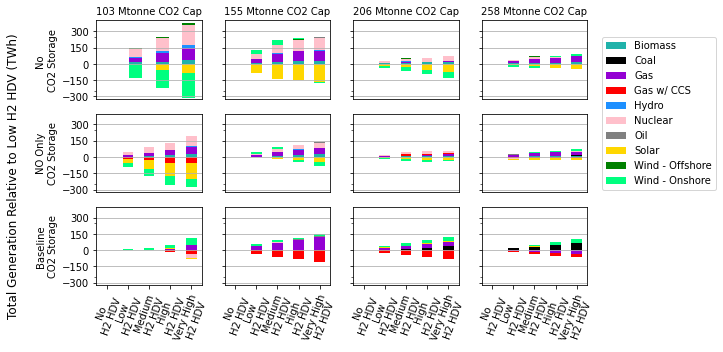

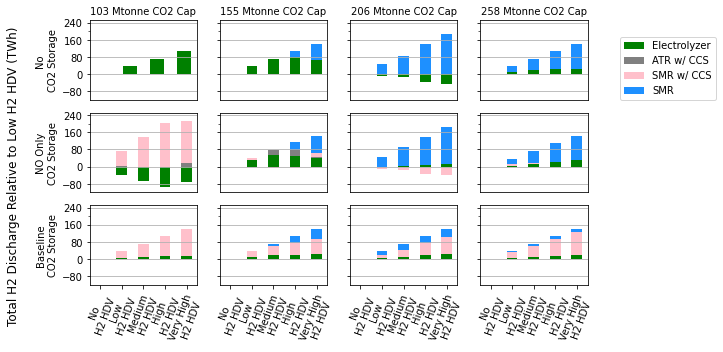

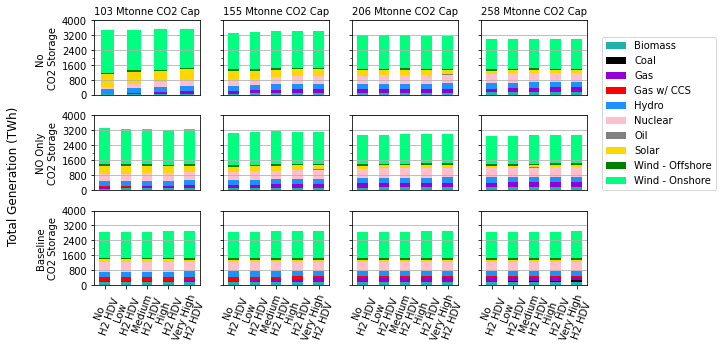

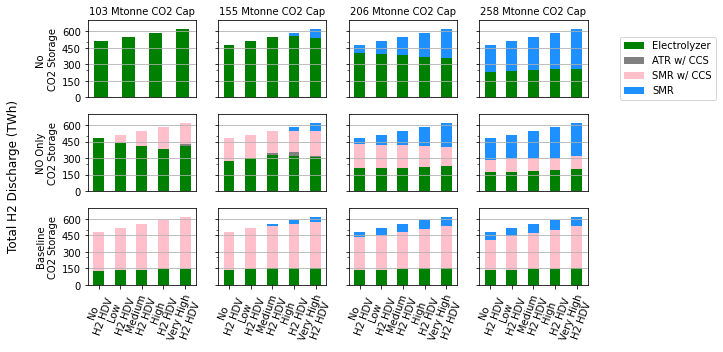

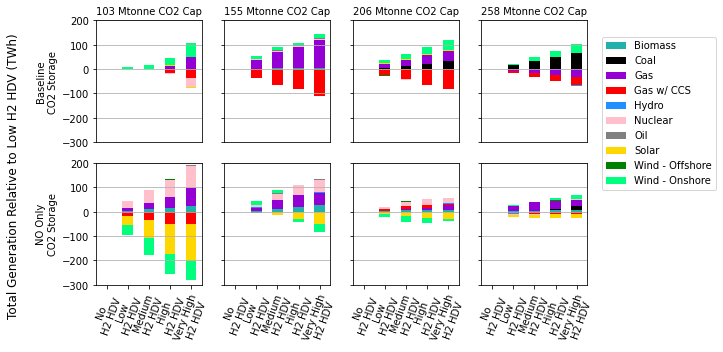

In [20]:
fig_compare_new( directory_name,[DATA_POWER_none[0],DATA_POWER_no_only_new[0], DATA_POWER_baseline_new[0]],
                "Power Generation Across Emissions and H2 HDV Adoption Scenarios",
                [s1_scenario_list_none_vals, s1_scenario_list_no_only_new_vals, s1_scenario_list_baseline_vals_new],
                group_by_CO2_cap = True, plot_type = "elec", relative = True, scenario_save = "dual_rel" , ylim = [-320, 400], reorder_groups = True,
               subplot_titles = ["103 Mtonne CO2 Cap", "155 Mtonne CO2 Cap", "206 Mtonne CO2 Cap", "258 Mtonne CO2 Cap"],
                labels = ['No\nH2 HDV', 'Low\nH2 HDV', 'Medium\nH2 HDV', 'High\nH2 HDV', 'Very High\nH2 HDV'],
               y_labels = ["No \nCO2 Storage", "NO Only\nCO2 Storage", "Baseline\nCO2 Storage"])

fig_compare_new( directory_name,[DATA_H2_none[0],DATA_H2_no_only_new[0], DATA_H2_baseline_new[0]],
                "Power Generation Across Emissions and H2 HDV Adoption Scenarios",
                [s1_scenario_list_none_vals, s1_scenario_list_no_only_new_vals, s1_scenario_list_baseline_vals_new],
                group_by_CO2_cap = True, plot_type = "h2", relative = True, scenario_save = "dual_rel" , ylim = [-120, 250], reorder_groups = True,
               subplot_titles = ["103 Mtonne CO2 Cap", "155 Mtonne CO2 Cap", "206 Mtonne CO2 Cap", "258 Mtonne CO2 Cap"],
                labels = ['No\nH2 HDV', 'Low\nH2 HDV', 'Medium\nH2 HDV', 'High\nH2 HDV', 'Very High\nH2 HDV'],
               y_labels = ["No \nCO2 Storage", "NO Only\nCO2 Storage", "Baseline\nCO2 Storage"])



fig_compare_new( directory_name,[DATA_POWER_none[0],DATA_POWER_no_only_new[0], DATA_POWER_baseline_new[0]],
                "Power Generation Across Emissions and H2 HDV Adoption Scenarios",
                [s1_scenario_list_none_vals, s1_scenario_list_no_only_new_vals, s1_scenario_list_baseline_vals_new],
                group_by_CO2_cap = True, plot_type = "elec", relative = False, scenario_save = "dual_rel" , ylim = [0, 4000], reorder_groups = True,
               subplot_titles = ["103 Mtonne CO2 Cap", "155 Mtonne CO2 Cap", "206 Mtonne CO2 Cap", "258 Mtonne CO2 Cap"],
                labels = ['No\nH2 HDV', 'Low\nH2 HDV', 'Medium\nH2 HDV', 'High\nH2 HDV', 'Very High\nH2 HDV'],
               y_labels = ["No \nCO2 Storage", "NO Only\nCO2 Storage", "Baseline\nCO2 Storage"])

fig_compare_new( directory_name,[DATA_H2_none[0],DATA_H2_no_only_new[0], DATA_H2_baseline_new[0]],
                "Power Generation Across Emissions and H2 HDV Adoption Scenarios",
                [s1_scenario_list_none_vals, s1_scenario_list_no_only_new_vals, s1_scenario_list_baseline_vals_new],
                group_by_CO2_cap = True, plot_type = "h2", relative = False, scenario_save = "dual_rel" , ylim = [0, 700], reorder_groups = True,
               subplot_titles = ["103 Mtonne CO2 Cap", "155 Mtonne CO2 Cap", "206 Mtonne CO2 Cap", "258 Mtonne CO2 Cap"],
                labels = ['No\nH2 HDV', 'Low\nH2 HDV', 'Medium\nH2 HDV', 'High\nH2 HDV', 'Very High\nH2 HDV'],
               y_labels = ["No \nCO2 Storage", "NO Only\nCO2 Storage", "Baseline\nCO2 Storage"])

fig_compare_new(directory_name,[DATA_POWER_baseline_new[0], DATA_POWER_no_only_new[0]],
                "Power Generation Across Emissions and H2 HDV Adoption Scenarios",
                [s1_scenario_list_baseline_vals_new, s1_scenario_list_no_only_new_vals],
                group_by_CO2_cap = True, plot_type = "elec", relative = True, scenario_save = "dual_rel" , ylim = [-300, 200], reorder_groups = True,
               subplot_titles = ["103 Mtonne CO2 Cap", "155 Mtonne CO2 Cap", "206 Mtonne CO2 Cap", "258 Mtonne CO2 Cap"],
                labels = ['No\nH2 HDV', 'Low\nH2 HDV', 'Medium\nH2 HDV', 'High\nH2 HDV', 'Very High\nH2 HDV'],
               y_labels = ["Baseline\nCO2 Storage", "NO Only\nCO2 Storage"])




fig_compare_new(directory_name,DATA_POWER_baseline_new[0], DATA_POWER_no_only_new[0],  "Power Generation Across Emissions and H2 HDV Adoption Scenarios",
                index_ordered_1 = s1_scenario_list_baseline_vals_new, index_ordered_2 = s1_scenario_list_no_only_new_vals,
                group_by_CO2_cap = True, plot_type = "elec", relative = True, scenario_save = "dual_rel" , ylim = [-300, 200], reorder_groups = True,
               subplot_titles = ["103 Mtonne CO2 Cap", "155 Mtonne CO2 Cap", "206 Mtonne CO2 Cap", "258 Mtonne CO2 Cap"],
                labels = ['No\nH2 HDV', 'Low\nH2 HDV', 'Medium\nH2 HDV', 'High\nH2 HDV', 'Very High\nH2 HDV'])


fig_compare_new(directory_name,DATA_H2_baseline_new[0], DATA_H2_no_only_new[0], "H2 Generation Across Emissions and H2 HDV Adoption Scenarios",
                index_ordered_1 = s1_scenario_list_baseline_vals_new, index_ordered_2 = s1_scenario_list_no_only_new_vals,
                group_by_CO2_cap = True, plot_type = "h2", relative = True, scenario_save = "dual_rel" , ylim = [-110, 230], reorder_groups = True,
               subplot_titles = ["103 Mtonne CO2 Cap", "155 Mtonne CO2 Cap", "206 Mtonne CO2 Cap", "258 Mtonne CO2 Cap"],
                labels = ['No\nH2 HDV', 'Low\nH2 HDV', 'Medium\nH2 HDV', 'High\nH2 HDV', 'Very High\nH2 HDV'])



### Power and H2 Comp Absolute

KeyError: 'generation_twh'

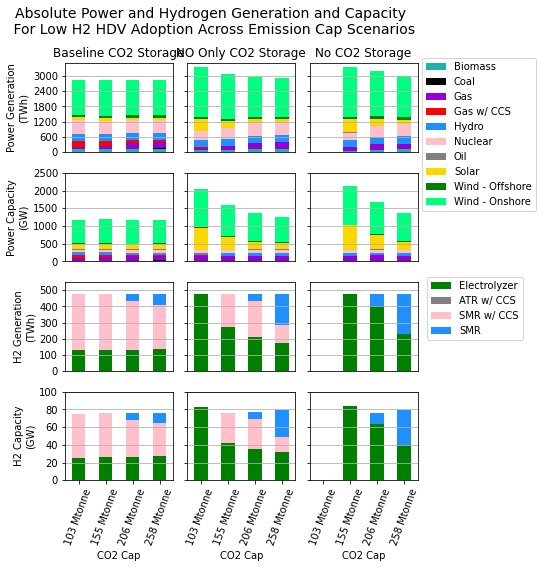

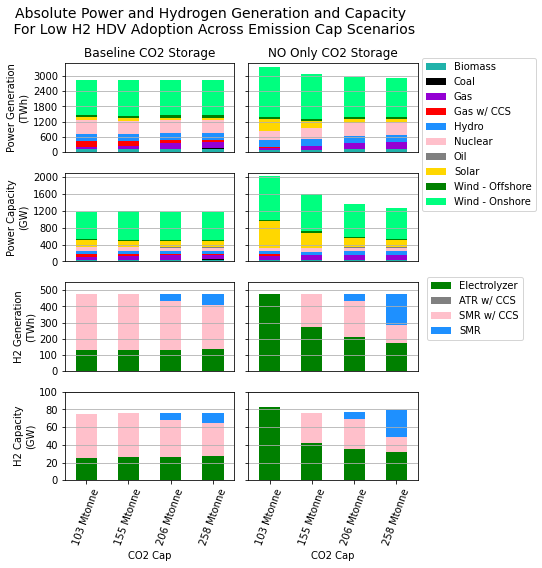

In [387]:
fig_compare_abs(directory_name,[DATA_POWER_baseline_new, DATA_POWER_no_only_new, DATA_POWER_none], [DATA_H2_baseline_new, DATA_H2_no_only_new, DATA_H2_none],
                "Absolute Power and Hydrogen Generation and Capacity \n For Low H2 HDV Adoption Across Emission Cap Scenarios",
                [s1_scenario_list_baseline_vals_new, s1_scenario_list_baseline_vals_new, s1_scenario_list_baseline_vals_new],
                 group_by_CO2_cap = False, relative = False, scenario_save = "dual_rel" , ylim_1 = [0, 3500],ylim_2 = [0, 2500], 
                ylim_3 = [0, 550], ylim_4 = [0, 100], reorder_groups = True,
               column_titles = ["Baseline CO2 Storage", "NO Only CO2 Storage", "No CO2 Storage"])


fig_compare_abs(directory_name,[DATA_POWER_baseline_new, DATA_POWER_no_only_new], [DATA_H2_baseline_new, DATA_H2_no_only_new],
                "Absolute Power and Hydrogen Generation and Capacity \n For Low H2 HDV Adoption Across Emission Cap Scenarios",
                [s1_scenario_list_baseline_vals_new, s1_scenario_list_baseline_vals_new],
                 group_by_CO2_cap = False, relative = False, scenario_save = "dual_rel" , ylim_1 = [0, 3500],ylim_2 = [0, 2100], 
                ylim_3 = [0, 550], ylim_4 = [0, 100], reorder_groups = True)

fig_compare_abs(directory_name,
                [DATA_POWER_baseline, DATA_POWER_no_only],
                [DATA_H2_baseline, DATA_H2_no_only],
                "Absolute Power and Hydrogen Generation and Capacity \n For Low H2 HDV Adoption Across Emission Cap Scenarios",
                [s1_scenario_list_baseline_vals,s1_scenario_list_baseline_vals],
                group_by_CO2_cap = False, relative = False, scenario_save = "dual_rel" , ylim_1 = [0, 3500],ylim_2 = [0, 2100], 
                ylim_3 = [0, 550], ylim_4 = [0, 100], reorder_groups = True)



### Emissions

<ipython-input-316-3bb5d176ab02>:88: UserWarning:

FixedFormatter should only be used together with FixedLocator



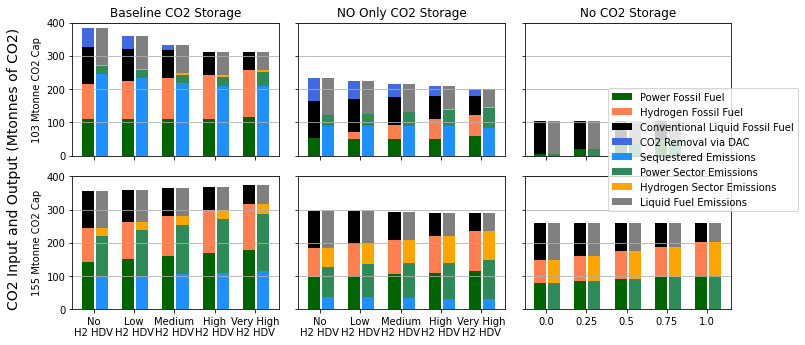

In [317]:
co2_percent_values = [0.4, 1.0]
create_double_subplots_for_co2_percent([DATA_EMISSIONS_baseline_new[0], DATA_EMISSIONS_no_only_new[0], DATA_EMISSIONS_none[0]], co2_percent_values, [0,400],
                                       ['No\nH2 HDV', 'Low\nH2 HDV', 'Medium\nH2 HDV', 'High\nH2 HDV', 'Very High\nH2 HDV'],
                                       ["103 Mtonne CO2 Cap", "155 Mtonne CO2 Cap", "206 Mtonne CO2 Cap", "258 Mtonne CO2 Cap"],
                                       fig_type = "no_sf")



### Cost

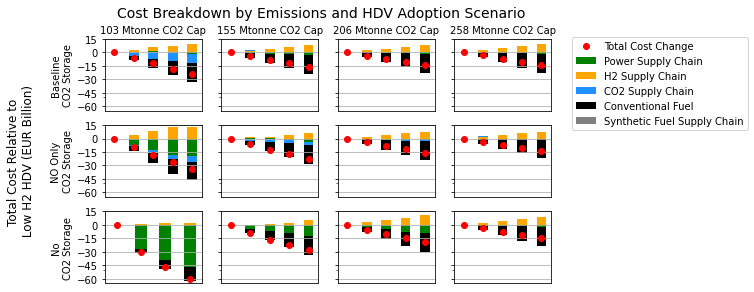

TypeError: plot_cost_dual() got an unexpected keyword argument 'df_1'

In [386]:
plot_cost_dual(df_list = [ DATA_COST_baseline_new,DATA_COST_no_only_new,DATA_COST_none],
               dist_lower = [1.1, 2.21, 3.31,4.42,0],
                 dist_upper = [1.73, 3.46, 5.19, 6.93,0],
                 title = 'Cost Breakdown by Emissions and HDV Adoption Scenario',
                 dir_name = directory_name,
                 relative = True, 
                 save_name =  'dual',
                 group_by = "CO2",
                 ylim = [-65,15],
              plot_dist = False)


plot_cost_dual(df_1 = DATA_COST_baseline,
               df_2 = DATA_COST_no_only,
               dist_lower = [1.1, 2.21, 3.31,4.42],
                 dist_upper = [1.73, 3.46, 5.19, 6.93],
                 title = 'Cost Breakdown by Emissions and HDV Adoption Scenario',
                 dir_name = directory_name,
                 relative = True, 
                 save_name =  'dual',
                 group_by = "CO2",
                 ylim = [-32,12],
              plot_dist = True)




## SF Figures

### Power and Hydrogen Comparison

FileNotFoundError: [Errno 2] No such file or directory: '/Users/youssefshaker/Dropbox (MIT)/Mobility_center_2021_projects/Liquid_Fuels/Input Construction/Demand/2023_Jan Non Trans Demand/Jul_13_Scenarios_v4_sf/Figures/elec_gen_sf_dual_rel.png'

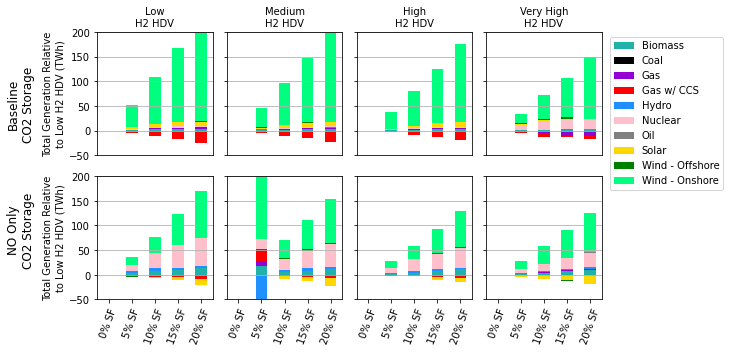

In [137]:
fig_compare_new(directory_name_sf,DATA_POWER_sf_baseline[0], DATA_POWER_sf_no_only[0],  "Power Generation Across Emissions and H2 HDV Adoption Scenarios",
                    index_ordered_1 = s1_scenario_list_sf_baseline_vals,index_ordered_2 = s1_scenario_list_sf_no_only_vals,
                group_by_CO2_cap = False, 
                plot_type = "elec", relative = True, scenario_save = "sf_dual_rel" , ylim = [-50, 200], reorder_groups = False)


fig_compare_new(directory_name_sf,DATA_H2_sf_baseline[0], DATA_H2_sf_no_only[0],  "H2 Generation Across Emissions and H2 HDV Adoption Scenarios",
                index_ordered_1 = s1_scenario_list_sf_baseline_vals,index_ordered_2 = s1_scenario_list_sf_no_only_vals,
            group_by_CO2_cap = False, plot_type = "h2", relative = True, scenario_save = "sf_dual_rel" , ylim = [-30, 130], reorder_groups = False)

### Emissions

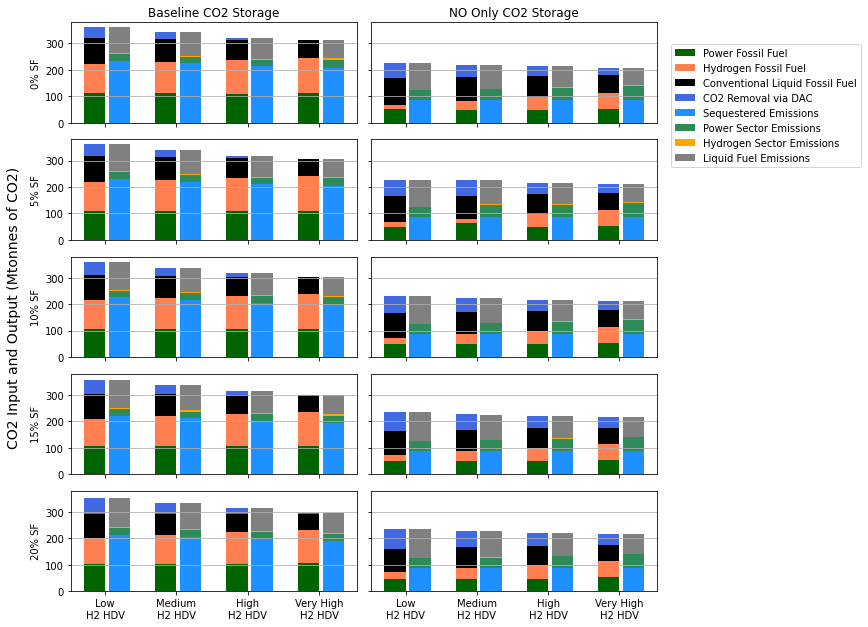

In [138]:
sf_percent_values = [0.00,0.05,0.10,0.15,0.20]
   
create_double_subplots_for_co2_percent(DATA_EMISSIONS_sf_baseline[0], DATA_EMISSIONS_sf_no_only[0], sf_percent_values, [0,380],
                                      ['Low\nH2 HDV', 'Medium\nH2 HDV', 'High\nH2 HDV', 'Very High\nH2 HDV'],
                                      ['0% SF', '5% SF', '10% SF', '15% SF', '20% SF'], fig_type = "sf")

### Cost

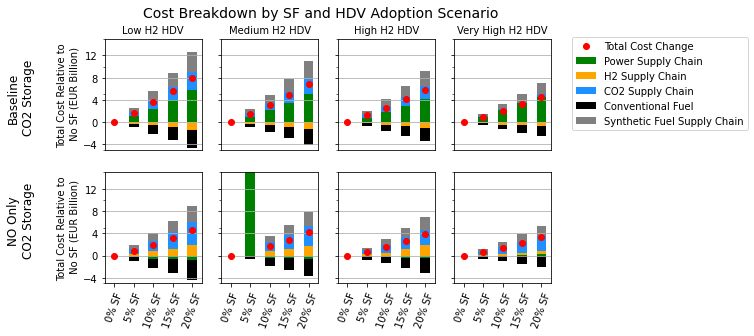

In [139]:
plot_cost_dual(df_1 = DATA_COST_sf_baseline,
               df_2 = DATA_COST_sf_no_only,
               dist_lower = None,
                 dist_upper = None,
                 title = 'Cost Breakdown by SF and HDV Adoption Scenario',
                 dir_name = directory_name,
                 relative = True, 
                 save_name =  'dual',
                 group_by = "h2",
                 ylim = [-5,15],
              plot_dist = False)
